In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'
                   ])
len(ondate_cols)

28

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.02,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.pyc'>

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('l2_3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(5803, 1, 28) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 252) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.800385
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.790633
[3]	valid_0's rmse: 0.781136
[4]	valid_0's rmse: 0.77203
[5]	valid_0's rmse: 0.763098
[6]	valid_0's rmse: 0.754383
[7]	valid_0's rmse: 0.74588
[8]	valid_0's rmse: 0.737645
[9]	valid_0's rmse: 0.729665
[10]	valid_0's rmse: 0.721887
[11]	valid_0's rmse: 0.714449
[12]	valid_0's rmse: 0.707155
[13]	valid_0's rmse: 0.700128
[14]	valid_0's rmse: 0.693241
[15]	valid_0's rmse: 0.686647
[16]	valid_0's rmse: 0.680171
[17]	valid_0's rmse: 0.673865
[18]	valid_0's rmse: 0.667822
[19]	valid_0's rmse: 0.6619
[20]	valid_0's rmse: 0.656171
[21]	valid_0's rmse: 0.650662
[22]	valid_0's rmse: 0.645272
[23]	valid_0's rmse: 0.640192
[24]	valid_0's rmse: 0.635162
[25]	valid_0's rmse: 0.63026
[26]	valid_0's rmse: 0.625529
[27]	valid_0's rmse: 0.620968
[28]	valid_0's rmse: 0.61652
[29]	valid_0's rmse: 0.612213
[30]	valid_0's rmse: 0.608067
[31]	valid_0's rmse: 0.604089
[32]	valid_0's rmse: 0.

[270]	valid_0's rmse: 0.495814
[271]	valid_0's rmse: 0.495825
[272]	valid_0's rmse: 0.495831
[273]	valid_0's rmse: 0.495821
[274]	valid_0's rmse: 0.495833
[275]	valid_0's rmse: 0.495845
[276]	valid_0's rmse: 0.495852
[277]	valid_0's rmse: 0.495869
[278]	valid_0's rmse: 0.495871
[279]	valid_0's rmse: 0.495861
[280]	valid_0's rmse: 0.495866
[281]	valid_0's rmse: 0.495865
[282]	valid_0's rmse: 0.495865
[283]	valid_0's rmse: 0.495862
[284]	valid_0's rmse: 0.495856
[285]	valid_0's rmse: 0.495843
[286]	valid_0's rmse: 0.495836
[287]	valid_0's rmse: 0.495842
[288]	valid_0's rmse: 0.495849
[289]	valid_0's rmse: 0.495849
[290]	valid_0's rmse: 0.495857
[291]	valid_0's rmse: 0.495857
[292]	valid_0's rmse: 0.495855
[293]	valid_0's rmse: 0.495849
[294]	valid_0's rmse: 0.495852
[295]	valid_0's rmse: 0.495843
[296]	valid_0's rmse: 0.495846
[297]	valid_0's rmse: 0.495845
[298]	valid_0's rmse: 0.495854
[299]	valid_0's rmse: 0.495844
[300]	valid_0's rmse: 0.495842
[301]	valid_0's rmse: 0.495841
[302]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912273  0.016837  0.211292    7  2017-04-16
472     2.507290  2.546200 -0.038910  0.209662    1  2017-04-17
473     2.661330  2.657990  0.003339  0.235396    2  2017-04-18
474     2.754815  2.746776  0.008038  0.194210    3  2017-04-19
475     2.713762  2.714131 -0.000370  0.219977    4  2017-04-20
476     2.999000  2.992066  0.006934  0.147649    5  2017-04-21
477     3.075529  3.094098 -0.018569  0.176333    6  2017-04-22

0.19921708784


pred         y     error    error2  day        date
dayidx                                                         
471     2.912273  2.929110  0.016837  0.211292    7  2017-04-16
472     2.546200  2.507290 -0.038910  0.209662    1  2017-04-17
473     2.657990  2.661330  0.003339  0.235396    2  2017-04-18
474     2.746776  2.754815  0.008038  0.194210    3  2017-04-19
475     2.714131  2.713762 -0.000370  0.219977    4  2017-04-20
476     2.992066  2.999000  0.006934  0.147649    5  2017-04-21
477     3.094098  3.075529 -0.018569  0.176333    6  2017-04-22

(829, 252)


2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(6632, 1, 28) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 252) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.490414
[237]	valid_0's rmse: 0.490402
[238]	valid_0's rmse: 0.490396
[239]	valid_0's rmse: 0.490403
[240]	valid_0's rmse: 0.490413
[241]	valid_0's rmse: 0.490417
[242]	valid_0's rmse: 0.490425
[243]	valid_0's rmse: 0.490425
[244]	valid_0's rmse: 0.490431
[245]	valid_0's rmse: 0.490425
[246]	valid_0's rmse: 0.490419
[247]	valid_0's rmse: 0.490419
[248]	valid_0's rmse: 0.49043
[249]	valid_0's rmse: 0.49043
[250]	valid_0's rmse: 0.490422
[251]	valid_0's rmse: 0.490415
[252]	valid_0's rmse: 0.490409
[253]	valid_0's rmse: 0.490422
[254]	valid_0's rmse: 0.490422
[255]	valid_0's rmse: 0.490431
[256]	valid_0's rmse: 0.490431
[257]	valid_0's rmse: 0.490422
[258]	valid_0's rmse: 0.49042
[259]	valid_0's rmse: 0.490419
[260]	valid_0's rmse: 0.490419
[261]	valid_0's rmse: 0.490429
[262]	valid_0's rmse: 0.490433
[263]	valid_0's rmse: 0.490441
[264]	valid_0's rmse: 0.490438
[265]	valid_0's rmse: 0.490435
[266]	valid_0's rmse: 0.490437
[267]	valid_0's rmse: 0.490428
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926283  0.002827  0.266035    7  2017-04-16
472     2.507290  2.618924 -0.111634  0.415365    1  2017-04-17
473     2.661330  2.738921 -0.077591  0.343863    2  2017-04-18
474     2.754815  2.771784 -0.016969  0.241020    3  2017-04-19
475     2.713762  2.745237 -0.031476  0.279041    4  2017-04-20
476     2.999000  3.019266 -0.020266  0.197036    5  2017-04-21
477     3.075529  3.088057 -0.012528  0.212109    6  2017-04-22

0.279209871925


pred         y     error    error2  day        date
dayidx                                                         
471     2.926283  2.929110  0.002827  0.266035    7  2017-04-16
472     2.618924  2.507290 -0.111634  0.415365    1  2017-04-17
473     2.738921  2.661330 -0.077591  0.343863    2  2017-04-18
474     2.771784  2.754815 -0.016969  0.241020    3  2017-04-19
475     2.745237  2.713762 -0.031476  0.279041    4  2017-04-20
476     3.019266  2.999000 -0.020266  0.197036    5  2017-04-21
477     3.088057  3.075529 -0.012528  0.212109    6  2017-04-22

(829, 252)


3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(7461, 1, 28) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 252) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.495335
[237]	valid_0's rmse: 0.495333
[238]	valid_0's rmse: 0.495345
[239]	valid_0's rmse: 0.495347
[240]	valid_0's rmse: 0.495347
[241]	valid_0's rmse: 0.495346
[242]	valid_0's rmse: 0.495355
[243]	valid_0's rmse: 0.495355
[244]	valid_0's rmse: 0.495325
[245]	valid_0's rmse: 0.495329
[246]	valid_0's rmse: 0.495305
[247]	valid_0's rmse: 0.495309
[248]	valid_0's rmse: 0.495308
[249]	valid_0's rmse: 0.495319
[250]	valid_0's rmse: 0.495318
[251]	valid_0's rmse: 0.495339
[252]	valid_0's rmse: 0.49535
[253]	valid_0's rmse: 0.495342
[254]	valid_0's rmse: 0.495344
[255]	valid_0's rmse: 0.495353
[256]	valid_0's rmse: 0.495347
[257]	valid_0's rmse: 0.495351
[258]	valid_0's rmse: 0.49535
[259]	valid_0's rmse: 0.49535
[260]	valid_0's rmse: 0.495347
[261]	valid_0's rmse: 0.495353
[262]	valid_0's rmse: 0.495361
[263]	valid_0's rmse: 0.495362
[264]	valid_0's rmse: 0.495359
[265]	valid_0's rmse: 0.495352
[266]	valid_0's rmse: 0.495345
[267]	valid_0's rmse: 0.495345
Early stopp

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895087  0.034023  0.242808    7  2017-04-16
472     2.507290  2.579480 -0.072190  0.290484    1  2017-04-17
473     2.661330  2.693786 -0.032457  0.411431    2  2017-04-18
474     2.754815  2.800718 -0.045903  0.341298    3  2017-04-19
475     2.713762  2.751598 -0.037837  0.303428    4  2017-04-20
476     2.999000  2.992708  0.006291  0.188065    5  2017-04-21
477     3.075529  3.079433 -0.003904  0.254232    6  2017-04-22

0.290249354676


pred         y     error    error2  day        date
dayidx                                                         
471     2.895087  2.929110  0.034023  0.242808    7  2017-04-16
472     2.579480  2.507290 -0.072190  0.290484    1  2017-04-17
473     2.693786  2.661330 -0.032457  0.411431    2  2017-04-18
474     2.800718  2.754815 -0.045903  0.341298    3  2017-04-19
475     2.751598  2.713762 -0.037837  0.303428    4  2017-04-20
476     2.992708  2.999000  0.006291  0.188065    5  2017-04-21
477     3.079433  3.075529 -0.003904  0.254232    6  2017-04-22

(829, 252)


4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(8290, 1, 28) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 252) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[234]	valid_0's rmse: 0.496243
[235]	valid_0's rmse: 0.49624
[236]	valid_0's rmse: 0.496246
[237]	valid_0's rmse: 0.496242
[238]	valid_0's rmse: 0.496249
[239]	valid_0's rmse: 0.496246
[240]	valid_0's rmse: 0.496237
[241]	valid_0's rmse: 0.496239
[242]	valid_0's rmse: 0.496241
[243]	valid_0's rmse: 0.496238
[244]	valid_0's rmse: 0.496242
[245]	valid_0's rmse: 0.496251
[246]	valid_0's rmse: 0.496256
[247]	valid_0's rmse: 0.496264
[248]	valid_0's rmse: 0.49626
[249]	valid_0's rmse: 0.496253
[250]	valid_0's rmse: 0.496267
[251]	valid_0's rmse: 0.496268
[252]	valid_0's rmse: 0.496271
[253]	valid_0's rmse: 0.496278
[254]	valid_0's rmse: 0.496269
[255]	valid_0's rmse: 0.49626
[256]	valid_0's rmse: 0.496263
[257]	valid_0's rmse: 0.496257
[258]	valid_0's rmse: 0.496267
[259]	valid_0's rmse: 0.49627
[260]	valid_0's rmse: 0.496272
[261]	valid_0's rmse: 0.496274
[262]	valid_0's rmse: 0.496265
[263]	valid_0's rmse: 0.496262
[264]	valid_0's rmse: 0.496261
[265]	valid_0's rmse: 0.496262
[266]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887800  0.041310  0.299819    7  2017-04-16
472     2.507290  2.557559 -0.050268  0.245273    1  2017-04-17
473     2.661330  2.680556 -0.019226  0.282023    2  2017-04-18
474     2.754815  2.728837  0.025978  0.360596    3  2017-04-19
475     2.713762  2.774370 -0.060609  0.338354    4  2017-04-20
476     2.999000  2.995829  0.003170  0.211026    5  2017-04-21
477     3.075529  3.043160  0.032369  0.253387    6  2017-04-22

0.284353973935


pred         y     error    error2  day        date
dayidx                                                         
471     2.887800  2.929110  0.041310  0.299819    7  2017-04-16
472     2.557559  2.507290 -0.050268  0.245273    1  2017-04-17
473     2.680556  2.661330 -0.019226  0.282023    2  2017-04-18
474     2.728837  2.754815  0.025978  0.360596    3  2017-04-19
475     2.774370  2.713762 -0.060609  0.338354    4  2017-04-20
476     2.995829  2.999000  0.003170  0.211026    5  2017-04-21
477     3.043160  3.075529  0.032369  0.253387    6  2017-04-22

(829, 252)


5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(9119, 1, 28) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 252) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.497613
[239]	valid_0's rmse: 0.497617
[240]	valid_0's rmse: 0.497616
[241]	valid_0's rmse: 0.497612
[242]	valid_0's rmse: 0.497611
[243]	valid_0's rmse: 0.497626
[244]	valid_0's rmse: 0.49762
[245]	valid_0's rmse: 0.497617
[246]	valid_0's rmse: 0.497622
[247]	valid_0's rmse: 0.497639
[248]	valid_0's rmse: 0.497625
[249]	valid_0's rmse: 0.497619
[250]	valid_0's rmse: 0.497617
[251]	valid_0's rmse: 0.497623
[252]	valid_0's rmse: 0.497619
[253]	valid_0's rmse: 0.497621
[254]	valid_0's rmse: 0.497629
[255]	valid_0's rmse: 0.497629
[256]	valid_0's rmse: 0.497634
[257]	valid_0's rmse: 0.497645
[258]	valid_0's rmse: 0.497654
[259]	valid_0's rmse: 0.49767
[260]	valid_0's rmse: 0.497679
[261]	valid_0's rmse: 0.497682
[262]	valid_0's rmse: 0.497708
[263]	valid_0's rmse: 0.497727
[264]	valid_0's rmse: 0.497728
[265]	valid_0's rmse: 0.497734
[266]	valid_0's rmse: 0.497737
[267]	valid_0's rmse: 0.497744
[268]	valid_0's rmse: 0.497747
[269]	valid_0's rmse: 0.497756
[270]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.875053  0.054057  0.331123    7  2017-04-16
472     2.507290  2.562693 -0.055402  0.277682    1  2017-04-17
473     2.661330  2.667518 -0.006188  0.271432    2  2017-04-18
474     2.754815  2.754755  0.000059  0.253901    3  2017-04-19
475     2.713762  2.718363 -0.004602  0.393878    4  2017-04-20
476     2.999000  2.992063  0.006937  0.283647    5  2017-04-21
477     3.075529  3.051838  0.023692  0.257844    6  2017-04-22

0.295643847225


pred         y     error    error2  day        date
dayidx                                                         
471     2.875053  2.929110  0.054057  0.331123    7  2017-04-16
472     2.562693  2.507290 -0.055402  0.277682    1  2017-04-17
473     2.667518  2.661330 -0.006188  0.271432    2  2017-04-18
474     2.754755  2.754815  0.000059  0.253901    3  2017-04-19
475     2.718363  2.713762 -0.004602  0.393878    4  2017-04-20
476     2.992063  2.999000  0.006937  0.283647    5  2017-04-21
477     3.051838  3.075529  0.023692  0.257844    6  2017-04-22

(829, 252)


6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 15.133374
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(9948, 1, 28) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 252) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[237]	valid_0's rmse: 0.497442
[238]	valid_0's rmse: 0.497446
[239]	valid_0's rmse: 0.497441
[240]	valid_0's rmse: 0.497435
[241]	valid_0's rmse: 0.497436
[242]	valid_0's rmse: 0.497431
[243]	valid_0's rmse: 0.497426
[244]	valid_0's rmse: 0.497419
[245]	valid_0's rmse: 0.497418
[246]	valid_0's rmse: 0.497417
[247]	valid_0's rmse: 0.497414
[248]	valid_0's rmse: 0.497414
[249]	valid_0's rmse: 0.497412
[250]	valid_0's rmse: 0.497426
[251]	valid_0's rmse: 0.49745
[252]	valid_0's rmse: 0.497448
[253]	valid_0's rmse: 0.497461
[254]	valid_0's rmse: 0.497474
[255]	valid_0's rmse: 0.497494
[256]	valid_0's rmse: 0.497486
[257]	valid_0's rmse: 0.497478
[258]	valid_0's rmse: 0.49748
[259]	valid_0's rmse: 0.497477
[260]	valid_0's rmse: 0.497477
[261]	valid_0's rmse: 0.497475
[262]	valid_0's rmse: 0.497477
[263]	valid_0's rmse: 0.497484
[264]	valid_0's rmse: 0.497489
[265]	valid_0's rmse: 0.497496
[266]	valid_0's rmse: 0.497505
[267]	valid_0's rmse: 0.497494
[268]	valid_0's rmse: 0.497501
[269]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893687  0.035423  0.330140    7  2017-04-16
472     2.507290  2.584128 -0.076837  0.303525    1  2017-04-17
473     2.661330  2.672660 -0.011331  0.295882    2  2017-04-18
474     2.754815  2.752082  0.002733  0.223567    3  2017-04-19
475     2.713762  2.728492 -0.014730  0.267990    4  2017-04-20
476     2.999000  2.914042  0.084958  0.337065    5  2017-04-21
477     3.075529  3.041918  0.033611  0.339988    6  2017-04-22

0.299736665597


pred         y     error    error2  day        date
dayidx                                                         
471     2.893687  2.929110  0.035423  0.330140    7  2017-04-16
472     2.584128  2.507290 -0.076837  0.303525    1  2017-04-17
473     2.672660  2.661330 -0.011331  0.295882    2  2017-04-18
474     2.752082  2.754815  0.002733  0.223567    3  2017-04-19
475     2.728492  2.713762 -0.014730  0.267990    4  2017-04-20
476     2.914042  2.999000  0.084958  0.337065    5  2017-04-21
477     3.041918  3.075529  0.033611  0.339988    6  2017-04-22

(829, 252)


7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 16.310143
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(10777, 1, 28) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 252) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.494918
[236]	valid_0's rmse: 0.494913
[237]	valid_0's rmse: 0.494912
[238]	valid_0's rmse: 0.49491
[239]	valid_0's rmse: 0.494908
[240]	valid_0's rmse: 0.494905
[241]	valid_0's rmse: 0.494902
[242]	valid_0's rmse: 0.494888
[243]	valid_0's rmse: 0.494878
[244]	valid_0's rmse: 0.494876
[245]	valid_0's rmse: 0.494874
[246]	valid_0's rmse: 0.494877
[247]	valid_0's rmse: 0.494867
[248]	valid_0's rmse: 0.494858
[249]	valid_0's rmse: 0.49486
[250]	valid_0's rmse: 0.494886
[251]	valid_0's rmse: 0.494881
[252]	valid_0's rmse: 0.494878
[253]	valid_0's rmse: 0.494878
[254]	valid_0's rmse: 0.494868
[255]	valid_0's rmse: 0.494867
[256]	valid_0's rmse: 0.494882
[257]	valid_0's rmse: 0.494879
[258]	valid_0's rmse: 0.494886
[259]	valid_0's rmse: 0.494887
[260]	valid_0's rmse: 0.494882
[261]	valid_0's rmse: 0.494877
[262]	valid_0's rmse: 0.494874
[263]	valid_0's rmse: 0.494875
[264]	valid_0's rmse: 0.494881
[265]	valid_0's rmse: 0.494878
[266]	valid_0's rmse: 0.494876
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908071  0.021039  0.353703    7  2017-04-16
472     2.507290  2.592612 -0.085322  0.306491    1  2017-04-17
473     2.661330  2.691891 -0.030561  0.314039    2  2017-04-18
474     2.754815  2.754035  0.000780  0.248442    3  2017-04-19
475     2.713762  2.729070 -0.015308  0.260123    4  2017-04-20
476     2.999000  2.997286  0.001714  0.196213    5  2017-04-21
477     3.075529  3.108666 -0.033137  0.322039    6  2017-04-22

0.285864225336


pred         y     error    error2  day        date
dayidx                                                         
471     2.908071  2.929110  0.021039  0.353703    7  2017-04-16
472     2.592612  2.507290 -0.085322  0.306491    1  2017-04-17
473     2.691891  2.661330 -0.030561  0.314039    2  2017-04-18
474     2.754035  2.754815  0.000780  0.248442    3  2017-04-19
475     2.729070  2.713762 -0.015308  0.260123    4  2017-04-20
476     2.997286  2.999000  0.001714  0.196213    5  2017-04-21
477     3.108666  3.075529 -0.033137  0.322039    6  2017-04-22

(829, 252)


8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 17.574337
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(11606, 1, 28) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 252) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.494416
[236]	valid_0's rmse: 0.494417
[237]	valid_0's rmse: 0.494411
[238]	valid_0's rmse: 0.494422
[239]	valid_0's rmse: 0.494435
[240]	valid_0's rmse: 0.494429
[241]	valid_0's rmse: 0.494423
[242]	valid_0's rmse: 0.494422
[243]	valid_0's rmse: 0.494429
[244]	valid_0's rmse: 0.494424
[245]	valid_0's rmse: 0.49442
[246]	valid_0's rmse: 0.494403
[247]	valid_0's rmse: 0.494404
[248]	valid_0's rmse: 0.494411
[249]	valid_0's rmse: 0.494407
[250]	valid_0's rmse: 0.494405
[251]	valid_0's rmse: 0.494402
[252]	valid_0's rmse: 0.494411
[253]	valid_0's rmse: 0.494411
[254]	valid_0's rmse: 0.494412
[255]	valid_0's rmse: 0.494412
[256]	valid_0's rmse: 0.494412
[257]	valid_0's rmse: 0.494412
[258]	valid_0's rmse: 0.494401
[259]	valid_0's rmse: 0.494408
[260]	valid_0's rmse: 0.494419
[261]	valid_0's rmse: 0.494416
[262]	valid_0's rmse: 0.494428
[263]	valid_0's rmse: 0.49443
[264]	valid_0's rmse: 0.494427
[265]	valid_0's rmse: 0.494424
[266]	valid_0's rmse: 0.49443
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.991826 -0.062716  0.354227    7  2017-04-16
472     2.507290  2.618477 -0.111186  0.325292    1  2017-04-17
473     2.661330  2.686489 -0.025159  0.290536    2  2017-04-18
474     2.754815  2.777788 -0.022973  0.280802    3  2017-04-19
475     2.713762  2.738760 -0.024998  0.280130    4  2017-04-20
476     2.999000  2.980112  0.018888  0.168342    5  2017-04-21
477     3.075529  3.108611 -0.033082  0.228276    6  2017-04-22

0.27537203197


pred         y     error    error2  day        date
dayidx                                                         
471     2.991826  2.929110 -0.062716  0.354227    7  2017-04-16
472     2.618477  2.507290 -0.111186  0.325292    1  2017-04-17
473     2.686489  2.661330 -0.025159  0.290536    2  2017-04-18
474     2.777788  2.754815 -0.022973  0.280802    3  2017-04-19
475     2.738760  2.713762 -0.024998  0.280130    4  2017-04-20
476     2.980112  2.999000  0.018888  0.168342    5  2017-04-21
477     3.108611  3.075529 -0.033082  0.228276    6  2017-04-22

(829, 252)


9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 18.806503
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(12435, 1, 28) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 252) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.500314
[236]	valid_0's rmse: 0.500311
[237]	valid_0's rmse: 0.500328
[238]	valid_0's rmse: 0.50032
[239]	valid_0's rmse: 0.500319
[240]	valid_0's rmse: 0.500315
[241]	valid_0's rmse: 0.500326
[242]	valid_0's rmse: 0.50032
[243]	valid_0's rmse: 0.500323
[244]	valid_0's rmse: 0.500319
[245]	valid_0's rmse: 0.50031
[246]	valid_0's rmse: 0.500296
[247]	valid_0's rmse: 0.500288
[248]	valid_0's rmse: 0.500303
[249]	valid_0's rmse: 0.500307
[250]	valid_0's rmse: 0.500309
[251]	valid_0's rmse: 0.500303
[252]	valid_0's rmse: 0.500307
[253]	valid_0's rmse: 0.500323
[254]	valid_0's rmse: 0.500313
[255]	valid_0's rmse: 0.500319
[256]	valid_0's rmse: 0.500328
[257]	valid_0's rmse: 0.500328
[258]	valid_0's rmse: 0.500329
[259]	valid_0's rmse: 0.50033
[260]	valid_0's rmse: 0.500345
[261]	valid_0's rmse: 0.500339
[262]	valid_0's rmse: 0.50035
[263]	valid_0's rmse: 0.500338
[264]	valid_0's rmse: 0.500339
[265]	valid_0's rmse: 0.500331
[266]	valid_0's rmse: 0.500334
[267]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917937  0.011173  0.262306    7  2017-04-16
472     2.507290  2.635301 -0.128011  0.435903    1  2017-04-17
473     2.661330  2.743194 -0.081865  0.382279    2  2017-04-18
474     2.754815  2.764782 -0.009967  0.268608    3  2017-04-19
475     2.713762  2.752425 -0.038664  0.308974    4  2017-04-20
476     2.999000  2.991596  0.007403  0.202373    5  2017-04-21
477     3.075529  3.094375 -0.018846  0.219992    6  2017-04-22

0.297205146181


pred         y     error    error2  day        date
dayidx                                                         
471     2.917937  2.929110  0.011173  0.262306    7  2017-04-16
472     2.635301  2.507290 -0.128011  0.435903    1  2017-04-17
473     2.743194  2.661330 -0.081865  0.382279    2  2017-04-18
474     2.764782  2.754815 -0.009967  0.268608    3  2017-04-19
475     2.752425  2.713762 -0.038664  0.308974    4  2017-04-20
476     2.991596  2.999000  0.007403  0.202373    5  2017-04-21
477     3.094375  3.075529 -0.018846  0.219992    6  2017-04-22

(829, 252)


10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 19.926521
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(13264, 1, 28) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 252) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.505205
[235]	valid_0's rmse: 0.505211
[236]	valid_0's rmse: 0.505213
[237]	valid_0's rmse: 0.505196
[238]	valid_0's rmse: 0.505203
[239]	valid_0's rmse: 0.505204
[240]	valid_0's rmse: 0.505188
[241]	valid_0's rmse: 0.505199
[242]	valid_0's rmse: 0.505193
[243]	valid_0's rmse: 0.505179
[244]	valid_0's rmse: 0.505187
[245]	valid_0's rmse: 0.505192
[246]	valid_0's rmse: 0.505191
[247]	valid_0's rmse: 0.505194
[248]	valid_0's rmse: 0.505198
[249]	valid_0's rmse: 0.505196
[250]	valid_0's rmse: 0.505201
[251]	valid_0's rmse: 0.505208
[252]	valid_0's rmse: 0.5052
[253]	valid_0's rmse: 0.505205
[254]	valid_0's rmse: 0.505197
[255]	valid_0's rmse: 0.505203
[256]	valid_0's rmse: 0.50521
[257]	valid_0's rmse: 0.505217
[258]	valid_0's rmse: 0.505224
[259]	valid_0's rmse: 0.505214
[260]	valid_0's rmse: 0.505208
[261]	valid_0's rmse: 0.505211
[262]	valid_0's rmse: 0.505198
[263]	valid_0's rmse: 0.505221
[264]	valid_0's rmse: 0.505227
[265]	valid_0's rmse: 0.505233
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901741  0.027368  0.261668    7  2017-04-16
472     2.507290  2.572469 -0.065178  0.278208    1  2017-04-17
473     2.661330  2.689046 -0.027716  0.406616    2  2017-04-18
474     2.754815  2.790380 -0.035565  0.334159    3  2017-04-19
475     2.713762  2.755122 -0.041360  0.292656    4  2017-04-20
476     2.999000  2.982784  0.016216  0.210769    5  2017-04-21
477     3.075529  3.077211 -0.001681  0.250816    6  2017-04-22

0.290698688036


pred         y     error    error2  day        date
dayidx                                                         
471     2.901741  2.929110  0.027368  0.261668    7  2017-04-16
472     2.572469  2.507290 -0.065178  0.278208    1  2017-04-17
473     2.689046  2.661330 -0.027716  0.406616    2  2017-04-18
474     2.790380  2.754815 -0.035565  0.334159    3  2017-04-19
475     2.755122  2.713762 -0.041360  0.292656    4  2017-04-20
476     2.982784  2.999000  0.016216  0.210769    5  2017-04-21
477     3.077211  3.075529 -0.001681  0.250816    6  2017-04-22

(829, 252)


11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 21.05768
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(14093, 1, 28) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 252) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.505779
[238]	valid_0's rmse: 0.505771
[239]	valid_0's rmse: 0.505762
[240]	valid_0's rmse: 0.505769
[241]	valid_0's rmse: 0.505763
[242]	valid_0's rmse: 0.505753
[243]	valid_0's rmse: 0.505749
[244]	valid_0's rmse: 0.50575
[245]	valid_0's rmse: 0.505755
[246]	valid_0's rmse: 0.505749
[247]	valid_0's rmse: 0.505744
[248]	valid_0's rmse: 0.505736
[249]	valid_0's rmse: 0.505742
[250]	valid_0's rmse: 0.505744
[251]	valid_0's rmse: 0.505746
[252]	valid_0's rmse: 0.505745
[253]	valid_0's rmse: 0.505755
[254]	valid_0's rmse: 0.505755
[255]	valid_0's rmse: 0.505735
[256]	valid_0's rmse: 0.505733
[257]	valid_0's rmse: 0.505727
[258]	valid_0's rmse: 0.505723
[259]	valid_0's rmse: 0.505716
[260]	valid_0's rmse: 0.505727
[261]	valid_0's rmse: 0.505713
[262]	valid_0's rmse: 0.505727
[263]	valid_0's rmse: 0.505737
[264]	valid_0's rmse: 0.505726
[265]	valid_0's rmse: 0.505722
[266]	valid_0's rmse: 0.505728
[267]	valid_0's rmse: 0.505737
[268]	valid_0's rmse: 0.505743
[269]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886189  0.042921  0.297906    7  2017-04-16
472     2.507290  2.570082 -0.062791  0.248477    1  2017-04-17
473     2.661330  2.680472 -0.019142  0.295649    2  2017-04-18
474     2.754815  2.748916  0.005899  0.369928    3  2017-04-19
475     2.713762  2.793772 -0.080010  0.360578    4  2017-04-20
476     2.999000  2.993560  0.005440  0.222777    5  2017-04-21
477     3.075529  3.048906  0.026623  0.261583    6  2017-04-22

0.293842577999


pred         y     error    error2  day        date
dayidx                                                         
471     2.886189  2.929110  0.042921  0.297906    7  2017-04-16
472     2.570082  2.507290 -0.062791  0.248477    1  2017-04-17
473     2.680472  2.661330 -0.019142  0.295649    2  2017-04-18
474     2.748916  2.754815  0.005899  0.369928    3  2017-04-19
475     2.793772  2.713762 -0.080010  0.360578    4  2017-04-20
476     2.993560  2.999000  0.005440  0.222777    5  2017-04-21
477     3.048906  3.075529  0.026623  0.261583    6  2017-04-22

(829, 252)


12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 22.115147
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(14922, 1, 28) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 252) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.508331
[237]	valid_0's rmse: 0.508335
[238]	valid_0's rmse: 0.508344
[239]	valid_0's rmse: 0.50834
[240]	valid_0's rmse: 0.508347
[241]	valid_0's rmse: 0.508333
[242]	valid_0's rmse: 0.508328
[243]	valid_0's rmse: 0.508347
[244]	valid_0's rmse: 0.508347
[245]	valid_0's rmse: 0.508351
[246]	valid_0's rmse: 0.508353
[247]	valid_0's rmse: 0.508349
[248]	valid_0's rmse: 0.508355
[249]	valid_0's rmse: 0.508346
[250]	valid_0's rmse: 0.508344
[251]	valid_0's rmse: 0.508343
[252]	valid_0's rmse: 0.508339
[253]	valid_0's rmse: 0.508355
[254]	valid_0's rmse: 0.508351
[255]	valid_0's rmse: 0.508359
[256]	valid_0's rmse: 0.508361
[257]	valid_0's rmse: 0.508361
[258]	valid_0's rmse: 0.508363
[259]	valid_0's rmse: 0.508366
[260]	valid_0's rmse: 0.508374
[261]	valid_0's rmse: 0.508367
[262]	valid_0's rmse: 0.508354
[263]	valid_0's rmse: 0.508348
[264]	valid_0's rmse: 0.508349
[265]	valid_0's rmse: 0.508349
[266]	valid_0's rmse: 0.508351
[267]	valid_0's rmse: 0.508362
[268]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.872678  0.056432  0.309951    7  2017-04-16
472     2.507290  2.571589 -0.064299  0.270956    1  2017-04-17
473     2.661330  2.677065 -0.015736  0.289419    2  2017-04-18
474     2.754815  2.739191  0.015624  0.247825    3  2017-04-19
475     2.713762  2.723851 -0.010089  0.384161    4  2017-04-20
476     2.999000  2.976677  0.022322  0.260065    5  2017-04-21
477     3.075529  3.053480  0.022049  0.258784    6  2017-04-22

0.288737365219


pred         y     error    error2  day        date
dayidx                                                         
471     2.872678  2.929110  0.056432  0.309951    7  2017-04-16
472     2.571589  2.507290 -0.064299  0.270956    1  2017-04-17
473     2.677065  2.661330 -0.015736  0.289419    2  2017-04-18
474     2.739191  2.754815  0.015624  0.247825    3  2017-04-19
475     2.723851  2.713762 -0.010089  0.384161    4  2017-04-20
476     2.976677  2.999000  0.022322  0.260065    5  2017-04-21
477     3.053480  3.075529  0.022049  0.258784    6  2017-04-22

(829, 252)


13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 23.15517
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(15751, 1, 28) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 252) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.507514
[237]	valid_0's rmse: 0.507519
[238]	valid_0's rmse: 0.507525
[239]	valid_0's rmse: 0.507524
[240]	valid_0's rmse: 0.507533
[241]	valid_0's rmse: 0.507538
[242]	valid_0's rmse: 0.507542
[243]	valid_0's rmse: 0.507532
[244]	valid_0's rmse: 0.507537
[245]	valid_0's rmse: 0.507552
[246]	valid_0's rmse: 0.507568
[247]	valid_0's rmse: 0.507576
[248]	valid_0's rmse: 0.507582
[249]	valid_0's rmse: 0.507574
[250]	valid_0's rmse: 0.50758
[251]	valid_0's rmse: 0.507585
[252]	valid_0's rmse: 0.507578
[253]	valid_0's rmse: 0.507573
[254]	valid_0's rmse: 0.507565
[255]	valid_0's rmse: 0.507572
[256]	valid_0's rmse: 0.507573
[257]	valid_0's rmse: 0.50757
[258]	valid_0's rmse: 0.507577
[259]	valid_0's rmse: 0.507575
[260]	valid_0's rmse: 0.507566
[261]	valid_0's rmse: 0.507571
[262]	valid_0's rmse: 0.507582
[263]	valid_0's rmse: 0.507586
[264]	valid_0's rmse: 0.507585
[265]	valid_0's rmse: 0.507588
[266]	valid_0's rmse: 0.50759
[267]	valid_0's rmse: 0.507584
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880118  0.048992  0.332463    7  2017-04-16
472     2.507290  2.577687 -0.070397  0.287194    1  2017-04-17
473     2.661330  2.692935 -0.031605  0.303836    2  2017-04-18
474     2.754815  2.747947  0.006868  0.253695    3  2017-04-19
475     2.713762  2.742748 -0.028986  0.274386    4  2017-04-20
476     2.999000  2.925028  0.073971  0.341337    5  2017-04-21
477     3.075529  3.046208  0.029321  0.309781    6  2017-04-22

0.300384598292


pred         y     error    error2  day        date
dayidx                                                         
471     2.880118  2.929110  0.048992  0.332463    7  2017-04-16
472     2.577687  2.507290 -0.070397  0.287194    1  2017-04-17
473     2.692935  2.661330 -0.031605  0.303836    2  2017-04-18
474     2.747947  2.754815  0.006868  0.253695    3  2017-04-19
475     2.742748  2.713762 -0.028986  0.274386    4  2017-04-20
476     2.925028  2.999000  0.073971  0.341337    5  2017-04-21
477     3.046208  3.075529  0.029321  0.309781    6  2017-04-22

(829, 252)


14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 24.22639
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(16580, 1, 28) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 252) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.503885
[238]	valid_0's rmse: 0.503878
[239]	valid_0's rmse: 0.50388
[240]	valid_0's rmse: 0.503882
[241]	valid_0's rmse: 0.503883
[242]	valid_0's rmse: 0.503885
[243]	valid_0's rmse: 0.503881
[244]	valid_0's rmse: 0.503873
[245]	valid_0's rmse: 0.503868
[246]	valid_0's rmse: 0.503861
[247]	valid_0's rmse: 0.503869
[248]	valid_0's rmse: 0.503867
[249]	valid_0's rmse: 0.503852
[250]	valid_0's rmse: 0.503843
[251]	valid_0's rmse: 0.503833
[252]	valid_0's rmse: 0.503841
[253]	valid_0's rmse: 0.50384
[254]	valid_0's rmse: 0.503848
[255]	valid_0's rmse: 0.50385
[256]	valid_0's rmse: 0.503844
[257]	valid_0's rmse: 0.503859
[258]	valid_0's rmse: 0.503872
[259]	valid_0's rmse: 0.50388
[260]	valid_0's rmse: 0.503873
[261]	valid_0's rmse: 0.503869
[262]	valid_0's rmse: 0.50387
[263]	valid_0's rmse: 0.503868
[264]	valid_0's rmse: 0.503857
[265]	valid_0's rmse: 0.503854
[266]	valid_0's rmse: 0.503856
[267]	valid_0's rmse: 0.503854
[268]	valid_0's rmse: 0.503851
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892566  0.036544  0.379450    7  2017-04-16
472     2.507290  2.572536 -0.065246  0.264189    1  2017-04-17
473     2.661330  2.686630 -0.025300  0.312154    2  2017-04-18
474     2.754815  2.750245  0.004570  0.262149    3  2017-04-19
475     2.713762  2.745717 -0.031955  0.266477    4  2017-04-20
476     2.999000  2.991424  0.007576  0.191144    5  2017-04-21
477     3.075529  3.101528 -0.025999  0.314578    6  2017-04-22

0.284305619417


pred         y     error    error2  day        date
dayidx                                                         
471     2.892566  2.929110  0.036544  0.379450    7  2017-04-16
472     2.572536  2.507290 -0.065246  0.264189    1  2017-04-17
473     2.686630  2.661330 -0.025300  0.312154    2  2017-04-18
474     2.750245  2.754815  0.004570  0.262149    3  2017-04-19
475     2.745717  2.713762 -0.031955  0.266477    4  2017-04-20
476     2.991424  2.999000  0.007576  0.191144    5  2017-04-21
477     3.101528  3.075529 -0.025999  0.314578    6  2017-04-22

(829, 252)


15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 25.357664
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(17409, 1, 28) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 252) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.502598
[236]	valid_0's rmse: 0.502599
[237]	valid_0's rmse: 0.502616
[238]	valid_0's rmse: 0.502612
[239]	valid_0's rmse: 0.502616
[240]	valid_0's rmse: 0.50261
[241]	valid_0's rmse: 0.502609
[242]	valid_0's rmse: 0.502594
[243]	valid_0's rmse: 0.502595
[244]	valid_0's rmse: 0.502607
[245]	valid_0's rmse: 0.50261
[246]	valid_0's rmse: 0.502605
[247]	valid_0's rmse: 0.502619
[248]	valid_0's rmse: 0.502609
[249]	valid_0's rmse: 0.502613
[250]	valid_0's rmse: 0.502608
[251]	valid_0's rmse: 0.502614
[252]	valid_0's rmse: 0.502619
[253]	valid_0's rmse: 0.502632
[254]	valid_0's rmse: 0.50264
[255]	valid_0's rmse: 0.502654
[256]	valid_0's rmse: 0.502659
[257]	valid_0's rmse: 0.502659
[258]	valid_0's rmse: 0.502662
[259]	valid_0's rmse: 0.502652
[260]	valid_0's rmse: 0.502653
[261]	valid_0's rmse: 0.502653
[262]	valid_0's rmse: 0.502654
[263]	valid_0's rmse: 0.502649
[264]	valid_0's rmse: 0.502653
[265]	valid_0's rmse: 0.502651
[266]	valid_0's rmse: 0.502656
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.971147 -0.042037  0.351214    7  2017-04-16
472     2.507290  2.601177 -0.093886  0.318509    1  2017-04-17
473     2.661330  2.680729 -0.019399  0.299349    2  2017-04-18
474     2.754815  2.765474 -0.010660  0.267066    3  2017-04-19
475     2.713762  2.761183 -0.047421  0.284769    4  2017-04-20
476     2.999000  2.996329  0.002670  0.172391    5  2017-04-21
477     3.075529  3.098741 -0.023212  0.215279    6  2017-04-22

0.272653902712


pred         y     error    error2  day        date
dayidx                                                         
471     2.971147  2.929110 -0.042037  0.351214    7  2017-04-16
472     2.601177  2.507290 -0.093886  0.318509    1  2017-04-17
473     2.680729  2.661330 -0.019399  0.299349    2  2017-04-18
474     2.765474  2.754815 -0.010660  0.267066    3  2017-04-19
475     2.761183  2.713762 -0.047421  0.284769    4  2017-04-20
476     2.996329  2.999000  0.002670  0.172391    5  2017-04-21
477     3.098741  3.075529 -0.023212  0.215279    6  2017-04-22

(829, 252)


16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 26.465925
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(18238, 1, 28) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 252) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.508902
[235]	valid_0's rmse: 0.508903
[236]	valid_0's rmse: 0.508912
[237]	valid_0's rmse: 0.50891
[238]	valid_0's rmse: 0.508913
[239]	valid_0's rmse: 0.508906
[240]	valid_0's rmse: 0.508903
[241]	valid_0's rmse: 0.508899
[242]	valid_0's rmse: 0.50891
[243]	valid_0's rmse: 0.508914
[244]	valid_0's rmse: 0.50892
[245]	valid_0's rmse: 0.508916
[246]	valid_0's rmse: 0.508915
[247]	valid_0's rmse: 0.508919
[248]	valid_0's rmse: 0.508929
[249]	valid_0's rmse: 0.508943
[250]	valid_0's rmse: 0.508953
[251]	valid_0's rmse: 0.508951
[252]	valid_0's rmse: 0.508954
[253]	valid_0's rmse: 0.508951
[254]	valid_0's rmse: 0.508954
[255]	valid_0's rmse: 0.508972
[256]	valid_0's rmse: 0.508975
[257]	valid_0's rmse: 0.508972
[258]	valid_0's rmse: 0.508964
[259]	valid_0's rmse: 0.508951
[260]	valid_0's rmse: 0.508942
[261]	valid_0's rmse: 0.508939
[262]	valid_0's rmse: 0.508946
[263]	valid_0's rmse: 0.508941
[264]	valid_0's rmse: 0.508941
[265]	valid_0's rmse: 0.508953
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894574  0.034536  0.267394    7  2017-04-16
472     2.507290  2.649088 -0.141798  0.445813    1  2017-04-17
473     2.661330  2.736553 -0.075223  0.366325    2  2017-04-18
474     2.754815  2.750209  0.004606  0.267765    3  2017-04-19
475     2.713762  2.754266 -0.040505  0.312202    4  2017-04-20
476     2.999000  3.003350 -0.004350  0.208788    5  2017-04-21
477     3.075529  3.078005 -0.002475  0.215019    6  2017-04-22

0.297615198607


pred         y     error    error2  day        date
dayidx                                                         
471     2.894574  2.929110  0.034536  0.267394    7  2017-04-16
472     2.649088  2.507290 -0.141798  0.445813    1  2017-04-17
473     2.736553  2.661330 -0.075223  0.366325    2  2017-04-18
474     2.750209  2.754815  0.004606  0.267765    3  2017-04-19
475     2.754266  2.713762 -0.040505  0.312202    4  2017-04-20
476     3.003350  2.999000 -0.004350  0.208788    5  2017-04-21
477     3.078005  3.075529 -0.002475  0.215019    6  2017-04-22

(829, 252)


17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 27.605818
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(19067, 1, 28) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 252) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.511676
[238]	valid_0's rmse: 0.511683
[239]	valid_0's rmse: 0.51169
[240]	valid_0's rmse: 0.511683
[241]	valid_0's rmse: 0.511689
[242]	valid_0's rmse: 0.511682
[243]	valid_0's rmse: 0.511667
[244]	valid_0's rmse: 0.511675
[245]	valid_0's rmse: 0.511662
[246]	valid_0's rmse: 0.511664
[247]	valid_0's rmse: 0.511671
[248]	valid_0's rmse: 0.511663
[249]	valid_0's rmse: 0.511659
[250]	valid_0's rmse: 0.511665
[251]	valid_0's rmse: 0.51167
[252]	valid_0's rmse: 0.511679
[253]	valid_0's rmse: 0.511678
[254]	valid_0's rmse: 0.511674
[255]	valid_0's rmse: 0.511677
[256]	valid_0's rmse: 0.511668
[257]	valid_0's rmse: 0.51167
[258]	valid_0's rmse: 0.51168
[259]	valid_0's rmse: 0.511675
[260]	valid_0's rmse: 0.511678
[261]	valid_0's rmse: 0.511675
[262]	valid_0's rmse: 0.511684
[263]	valid_0's rmse: 0.511687
[264]	valid_0's rmse: 0.511689
[265]	valid_0's rmse: 0.511683
[266]	valid_0's rmse: 0.511671
[267]	valid_0's rmse: 0.511673
[268]	valid_0's rmse: 0.511691
[269]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884421  0.044689  0.264277    7  2017-04-16
472     2.507290  2.551666 -0.044375  0.265940    1  2017-04-17
473     2.661330  2.678538 -0.017208  0.410365    2  2017-04-18
474     2.754815  2.770815 -0.016000  0.338863    3  2017-04-19
475     2.713762  2.752204 -0.038443  0.308632    4  2017-04-20
476     2.999000  2.997435  0.001565  0.213096    5  2017-04-21
477     3.075529  3.054743  0.020786  0.248613    6  2017-04-22

0.292826708905


pred         y     error    error2  day        date
dayidx                                                         
471     2.884421  2.929110  0.044689  0.264277    7  2017-04-16
472     2.551666  2.507290 -0.044375  0.265940    1  2017-04-17
473     2.678538  2.661330 -0.017208  0.410365    2  2017-04-18
474     2.770815  2.754815 -0.016000  0.338863    3  2017-04-19
475     2.752204  2.713762 -0.038443  0.308632    4  2017-04-20
476     2.997435  2.999000  0.001565  0.213096    5  2017-04-21
477     3.054743  3.075529  0.020786  0.248613    6  2017-04-22

(829, 252)


18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 28.75126
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(19896, 1, 28) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 252) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.513347
[237]	valid_0's rmse: 0.513352
[238]	valid_0's rmse: 0.513354
[239]	valid_0's rmse: 0.51336
[240]	valid_0's rmse: 0.51335
[241]	valid_0's rmse: 0.513355
[242]	valid_0's rmse: 0.513356
[243]	valid_0's rmse: 0.513341
[244]	valid_0's rmse: 0.51333
[245]	valid_0's rmse: 0.513321
[246]	valid_0's rmse: 0.513323
[247]	valid_0's rmse: 0.513322
[248]	valid_0's rmse: 0.513332
[249]	valid_0's rmse: 0.513339
[250]	valid_0's rmse: 0.513325
[251]	valid_0's rmse: 0.513319
[252]	valid_0's rmse: 0.513317
[253]	valid_0's rmse: 0.513318
[254]	valid_0's rmse: 0.513335
[255]	valid_0's rmse: 0.513338
[256]	valid_0's rmse: 0.513348
[257]	valid_0's rmse: 0.513353
Early stopping, best iteration is:
[207]	valid_0's rmse: 0.513241
0.23886378477303558 0.2634166237312695
[0.2634166237312695]
-1 mean score 0.2634166237312695
0.290747022645


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885503  0.043607  0.309184    7  2017-04-16
472     2.507290  2.543326 -0.036036  0.241069    1  2017-04-17
473     2.661330  2.665925 -0.004595  0.299666    2  2017-04-18
474     2.754815  2.736935  0.017880  0.364559    3  2017-04-19
475     2.713762  2.774930 -0.061168  0.341339    4  2017-04-20
476     2.999000  2.989729  0.009271  0.228386    5  2017-04-21
477     3.075529  3.040761  0.034768  0.251026    6  2017-04-22

0.290747022645


pred         y     error    error2  day        date
dayidx                                                         
471     2.885503  2.929110  0.043607  0.309184    7  2017-04-16
472     2.543326  2.507290 -0.036036  0.241069    1  2017-04-17
473     2.665925  2.661330 -0.004595  0.299666    2  2017-04-18
474     2.736935  2.754815  0.017880  0.364559    3  2017-04-19
475     2.774930  2.713762 -0.061168  0.341339    4  2017-04-20
476     2.989729  2.999000  0.009271  0.228386    5  2017-04-21
477     3.040761  3.075529  0.034768  0.251026    6  2017-04-22

(829, 252)


19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 29.798643
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(20725, 1, 28) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 252) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.514355
[236]	valid_0's rmse: 0.51435
[237]	valid_0's rmse: 0.514354
[238]	valid_0's rmse: 0.514345
[239]	valid_0's rmse: 0.514351
[240]	valid_0's rmse: 0.514347
[241]	valid_0's rmse: 0.514347
[242]	valid_0's rmse: 0.514359
[243]	valid_0's rmse: 0.514367
[244]	valid_0's rmse: 0.51437
[245]	valid_0's rmse: 0.514364
[246]	valid_0's rmse: 0.514367
[247]	valid_0's rmse: 0.51437
[248]	valid_0's rmse: 0.51436
[249]	valid_0's rmse: 0.514341
[250]	valid_0's rmse: 0.514338
[251]	valid_0's rmse: 0.514336
[252]	valid_0's rmse: 0.514346
[253]	valid_0's rmse: 0.51434
[254]	valid_0's rmse: 0.514343
[255]	valid_0's rmse: 0.514349
[256]	valid_0's rmse: 0.514339
[257]	valid_0's rmse: 0.514339
[258]	valid_0's rmse: 0.514351
[259]	valid_0's rmse: 0.514355
[260]	valid_0's rmse: 0.514363
[261]	valid_0's rmse: 0.514361
[262]	valid_0's rmse: 0.514358
[263]	valid_0's rmse: 0.51437
[264]	valid_0's rmse: 0.51437
[265]	valid_0's rmse: 0.514377
[266]	valid_0's rmse: 0.514367
[267]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.867452  0.061658  0.320884    7  2017-04-16
472     2.507290  2.573246 -0.065956  0.301022    1  2017-04-17
473     2.661330  2.657455  0.003875  0.275774    2  2017-04-18
474     2.754815  2.723337  0.031478  0.259981    3  2017-04-19
475     2.713762  2.730967 -0.017205  0.396536    4  2017-04-20
476     2.999000  2.976302  0.022697  0.263018    5  2017-04-21
477     3.075529  3.035630  0.039899  0.270961    6  2017-04-22

0.298310962752


pred         y     error    error2  day        date
dayidx                                                         
471     2.867452  2.929110  0.061658  0.320884    7  2017-04-16
472     2.573246  2.507290 -0.065956  0.301022    1  2017-04-17
473     2.657455  2.661330  0.003875  0.275774    2  2017-04-18
474     2.723337  2.754815  0.031478  0.259981    3  2017-04-19
475     2.730967  2.713762 -0.017205  0.396536    4  2017-04-20
476     2.976302  2.999000  0.022697  0.263018    5  2017-04-21
477     3.035630  3.075529  0.039899  0.270961    6  2017-04-22

(829, 252)


20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 30.796307
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(21554, 1, 28) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 252) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.51461
[237]	valid_0's rmse: 0.514606
[238]	valid_0's rmse: 0.514611
[239]	valid_0's rmse: 0.514606
[240]	valid_0's rmse: 0.514611
[241]	valid_0's rmse: 0.514612
[242]	valid_0's rmse: 0.514623
[243]	valid_0's rmse: 0.514622
[244]	valid_0's rmse: 0.514612
[245]	valid_0's rmse: 0.514608
[246]	valid_0's rmse: 0.514614
[247]	valid_0's rmse: 0.514609
[248]	valid_0's rmse: 0.514618
[249]	valid_0's rmse: 0.514613
[250]	valid_0's rmse: 0.514624
[251]	valid_0's rmse: 0.514621
[252]	valid_0's rmse: 0.514626
[253]	valid_0's rmse: 0.514635
[254]	valid_0's rmse: 0.514638
[255]	valid_0's rmse: 0.514646
[256]	valid_0's rmse: 0.514643
[257]	valid_0's rmse: 0.514658
[258]	valid_0's rmse: 0.514678
[259]	valid_0's rmse: 0.514673
[260]	valid_0's rmse: 0.514676
[261]	valid_0's rmse: 0.514694
[262]	valid_0's rmse: 0.51469
[263]	valid_0's rmse: 0.514704
[264]	valid_0's rmse: 0.51471
[265]	valid_0's rmse: 0.514716
[266]	valid_0's rmse: 0.514724
[267]	valid_0's rmse: 0.514721
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.869600  0.059510  0.356342    7  2017-04-16
472     2.507290  2.578793 -0.071503  0.304277    1  2017-04-17
473     2.661330  2.678778 -0.017448  0.318186    2  2017-04-18
474     2.754815  2.727937  0.026878  0.238194    3  2017-04-19
475     2.713762  2.725579 -0.011817  0.275700    4  2017-04-20
476     2.999000  2.923676  0.075324  0.366430    5  2017-04-21
477     3.075529  3.032589  0.042940  0.310093    6  2017-04-22

0.30988879711


pred         y     error    error2  day        date
dayidx                                                         
471     2.869600  2.929110  0.059510  0.356342    7  2017-04-16
472     2.578793  2.507290 -0.071503  0.304277    1  2017-04-17
473     2.678778  2.661330 -0.017448  0.318186    2  2017-04-18
474     2.727937  2.754815  0.026878  0.238194    3  2017-04-19
475     2.725579  2.713762 -0.011817  0.275700    4  2017-04-20
476     2.923676  2.999000  0.075324  0.366430    5  2017-04-21
477     3.032589  3.075529  0.042940  0.310093    6  2017-04-22

(829, 252)


21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 31.792852
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(22383, 1, 28) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 252) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.51071
[237]	valid_0's rmse: 0.510716
[238]	valid_0's rmse: 0.510708
[239]	valid_0's rmse: 0.510713
[240]	valid_0's rmse: 0.510723
[241]	valid_0's rmse: 0.510719
[242]	valid_0's rmse: 0.510718
[243]	valid_0's rmse: 0.510727
[244]	valid_0's rmse: 0.510718
[245]	valid_0's rmse: 0.510717
[246]	valid_0's rmse: 0.510722
[247]	valid_0's rmse: 0.510738
[248]	valid_0's rmse: 0.51073
[249]	valid_0's rmse: 0.510735
[250]	valid_0's rmse: 0.510743
[251]	valid_0's rmse: 0.510744
[252]	valid_0's rmse: 0.510762
[253]	valid_0's rmse: 0.510774
[254]	valid_0's rmse: 0.51077
[255]	valid_0's rmse: 0.510777
[256]	valid_0's rmse: 0.510785
[257]	valid_0's rmse: 0.510787
Early stopping, best iteration is:
[207]	valid_0's rmse: 0.510595
0.2373861194614822 0.26070748743357586
[0.26070748743357586]
-1 mean score 0.26070748743357586
0.290834998386


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888737  0.040373  0.364736    7  2017-04-16
472     2.507290  2.562795 -0.055505  0.289834    1  2017-04-17
473     2.661330  2.687094 -0.025764  0.320990    2  2017-04-18
474     2.754815  2.747290  0.007524  0.275695    3  2017-04-19
475     2.713762  2.720663 -0.006901  0.254849    4  2017-04-20
476     2.999000  2.972418  0.026581  0.208684    5  2017-04-21
477     3.075529  3.082187 -0.006658  0.321057    6  2017-04-22

0.290834998386


pred         y     error    error2  day        date
dayidx                                                         
471     2.888737  2.929110  0.040373  0.364736    7  2017-04-16
472     2.562795  2.507290 -0.055505  0.289834    1  2017-04-17
473     2.687094  2.661330 -0.025764  0.320990    2  2017-04-18
474     2.747290  2.754815  0.007524  0.275695    3  2017-04-19
475     2.720663  2.713762 -0.006901  0.254849    4  2017-04-20
476     2.972418  2.999000  0.026581  0.208684    5  2017-04-21
477     3.082187  3.075529 -0.006658  0.321057    6  2017-04-22

(829, 252)


22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 32.870983
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(23212, 1, 28) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 252) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.508771
[237]	valid_0's rmse: 0.508769
[238]	valid_0's rmse: 0.508787
[239]	valid_0's rmse: 0.508782
[240]	valid_0's rmse: 0.508785
[241]	valid_0's rmse: 0.508784
[242]	valid_0's rmse: 0.508778
[243]	valid_0's rmse: 0.508785
[244]	valid_0's rmse: 0.508787
[245]	valid_0's rmse: 0.508795
[246]	valid_0's rmse: 0.508795
[247]	valid_0's rmse: 0.508798
[248]	valid_0's rmse: 0.508793
[249]	valid_0's rmse: 0.508806
[250]	valid_0's rmse: 0.508813
[251]	valid_0's rmse: 0.508815
[252]	valid_0's rmse: 0.508826
[253]	valid_0's rmse: 0.508825
[254]	valid_0's rmse: 0.508836
[255]	valid_0's rmse: 0.508838
[256]	valid_0's rmse: 0.508837
[257]	valid_0's rmse: 0.508825
[258]	valid_0's rmse: 0.508825
[259]	valid_0's rmse: 0.508836
[260]	valid_0's rmse: 0.508831
[261]	valid_0's rmse: 0.508843
[262]	valid_0's rmse: 0.50884
[263]	valid_0's rmse: 0.508838
[264]	valid_0's rmse: 0.508826
[265]	valid_0's rmse: 0.50882
[266]	valid_0's rmse: 0.508827
[267]	valid_0's rmse: 0.508815
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.958983 -0.029873  0.343972    7  2017-04-16
472     2.507290  2.575251 -0.067960  0.309370    1  2017-04-17
473     2.661330  2.673447 -0.012118  0.290722    2  2017-04-18
474     2.754815  2.761204 -0.006389  0.276424    3  2017-04-19
475     2.713762  2.748957 -0.035195  0.309475    4  2017-04-20
476     2.999000  2.975653  0.023347  0.196838    5  2017-04-21
477     3.075529  3.074478  0.001052  0.217326    6  2017-04-22

0.2777325443


pred         y     error    error2  day        date
dayidx                                                         
471     2.958983  2.929110 -0.029873  0.343972    7  2017-04-16
472     2.575251  2.507290 -0.067960  0.309370    1  2017-04-17
473     2.673447  2.661330 -0.012118  0.290722    2  2017-04-18
474     2.761204  2.754815 -0.006389  0.276424    3  2017-04-19
475     2.748957  2.713762 -0.035195  0.309475    4  2017-04-20
476     2.975653  2.999000  0.023347  0.196838    5  2017-04-21
477     3.074478  3.075529  0.001052  0.217326    6  2017-04-22

(829, 252)


23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 33.974537
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(24041, 1, 28) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 252) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.515969
[237]	valid_0's rmse: 0.515969
[238]	valid_0's rmse: 0.515967
[239]	valid_0's rmse: 0.51596
[240]	valid_0's rmse: 0.515945
[241]	valid_0's rmse: 0.515928
[242]	valid_0's rmse: 0.515928
[243]	valid_0's rmse: 0.515928
[244]	valid_0's rmse: 0.515933
[245]	valid_0's rmse: 0.515935
[246]	valid_0's rmse: 0.515923
[247]	valid_0's rmse: 0.515932
[248]	valid_0's rmse: 0.515927
Early stopping, best iteration is:
[198]	valid_0's rmse: 0.515826
0.2403522612028501 0.26607628741988587
[0.26607628741988587]
-1 mean score 0.26607628741988587
0.302056647692


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919179  0.009931  0.288591    7  2017-04-16
472     2.507290  2.652066 -0.144776  0.455865    1  2017-04-17
473     2.661330  2.736930 -0.075600  0.369295    2  2017-04-18
474     2.754815  2.757882 -0.003068  0.274060    3  2017-04-19
475     2.713762  2.756828 -0.043066  0.305507    4  2017-04-20
476     2.999000  2.985492  0.013508  0.216248    5  2017-04-21
477     3.075529  3.056483  0.019046  0.204831    6  2017-04-22

0.302056647692


pred         y     error    error2  day        date
dayidx                                                         
471     2.919179  2.929110  0.009931  0.288591    7  2017-04-16
472     2.652066  2.507290 -0.144776  0.455865    1  2017-04-17
473     2.736930  2.661330 -0.075600  0.369295    2  2017-04-18
474     2.757882  2.754815 -0.003068  0.274060    3  2017-04-19
475     2.756828  2.713762 -0.043066  0.305507    4  2017-04-20
476     2.985492  2.999000  0.013508  0.216248    5  2017-04-21
477     3.056483  3.075529  0.019046  0.204831    6  2017-04-22

(829, 252)


24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 35.208443
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(24870, 1, 28) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 252) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.516848
[237]	valid_0's rmse: 0.51685
[238]	valid_0's rmse: 0.516858
[239]	valid_0's rmse: 0.516855
[240]	valid_0's rmse: 0.51687
[241]	valid_0's rmse: 0.516886
[242]	valid_0's rmse: 0.516898
[243]	valid_0's rmse: 0.516897
[244]	valid_0's rmse: 0.516885
[245]	valid_0's rmse: 0.516894
[246]	valid_0's rmse: 0.516892
[247]	valid_0's rmse: 0.516891
[248]	valid_0's rmse: 0.516875
[249]	valid_0's rmse: 0.516886
[250]	valid_0's rmse: 0.516881
[251]	valid_0's rmse: 0.516889
[252]	valid_0's rmse: 0.5169
[253]	valid_0's rmse: 0.516905
[254]	valid_0's rmse: 0.516902
[255]	valid_0's rmse: 0.516897
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.516735
0.24115406970904363 0.2670149236298
[0.2670149236298]
-1 mean score 0.2670149236298
0.293663605407


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910436  0.018674  0.274246    7  2017-04-16
472     2.507290  2.539298 -0.032007  0.275194    1  2017-04-17
473     2.661330  2.701805 -0.040475  0.412291    2  2017-04-18
474     2.754815  2.786613 -0.031799  0.343437    3  2017-04-19
475     2.713762  2.738607 -0.024845  0.297766    4  2017-04-20
476     2.999000  2.987174  0.011825  0.216715    5  2017-04-21
477     3.075529  3.052585  0.022944  0.235998    6  2017-04-22

0.293663605407


pred         y     error    error2  day        date
dayidx                                                         
471     2.910436  2.929110  0.018674  0.274246    7  2017-04-16
472     2.539298  2.507290 -0.032007  0.275194    1  2017-04-17
473     2.701805  2.661330 -0.040475  0.412291    2  2017-04-18
474     2.786613  2.754815 -0.031799  0.343437    3  2017-04-19
475     2.738607  2.713762 -0.024845  0.297766    4  2017-04-20
476     2.987174  2.999000  0.011825  0.216715    5  2017-04-21
477     3.052585  3.075529  0.022944  0.235998    6  2017-04-22

(829, 252)


25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 36.335064
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(25699, 1, 28) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 252) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.519132
[235]	valid_0's rmse: 0.519128
[236]	valid_0's rmse: 0.519122
[237]	valid_0's rmse: 0.519117
[238]	valid_0's rmse: 0.519116
[239]	valid_0's rmse: 0.519105
[240]	valid_0's rmse: 0.519097
[241]	valid_0's rmse: 0.519093
[242]	valid_0's rmse: 0.519089
[243]	valid_0's rmse: 0.519091
[244]	valid_0's rmse: 0.519088
[245]	valid_0's rmse: 0.519095
[246]	valid_0's rmse: 0.5191
[247]	valid_0's rmse: 0.519078
[248]	valid_0's rmse: 0.519089
[249]	valid_0's rmse: 0.519087
[250]	valid_0's rmse: 0.519113
[251]	valid_0's rmse: 0.519113
[252]	valid_0's rmse: 0.519103
[253]	valid_0's rmse: 0.51909
[254]	valid_0's rmse: 0.519101
[255]	valid_0's rmse: 0.519085
[256]	valid_0's rmse: 0.519087
[257]	valid_0's rmse: 0.5191
[258]	valid_0's rmse: 0.519104
[259]	valid_0's rmse: 0.519115
[260]	valid_0's rmse: 0.519111
[261]	valid_0's rmse: 0.519095
[262]	valid_0's rmse: 0.519091
[263]	valid_0's rmse: 0.519088
[264]	valid_0's rmse: 0.519086
[265]	valid_0's rmse: 0.51909
Early stopping

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889419  0.039691  0.314658    7  2017-04-16
472     2.507290  2.540393 -0.033102  0.260791    1  2017-04-17
473     2.661330  2.657975  0.003355  0.290599    2  2017-04-18
474     2.754815  2.724322  0.030493  0.386730    3  2017-04-19
475     2.713762  2.758179 -0.044418  0.351661    4  2017-04-20
476     2.999000  2.971717  0.027283  0.223023    5  2017-04-21
477     3.075529  3.031901  0.043628  0.268596    6  2017-04-22

0.29943683493


pred         y     error    error2  day        date
dayidx                                                         
471     2.889419  2.929110  0.039691  0.314658    7  2017-04-16
472     2.540393  2.507290 -0.033102  0.260791    1  2017-04-17
473     2.657975  2.661330  0.003355  0.290599    2  2017-04-18
474     2.724322  2.754815  0.030493  0.386730    3  2017-04-19
475     2.758179  2.713762 -0.044418  0.351661    4  2017-04-20
476     2.971717  2.999000  0.027283  0.223023    5  2017-04-21
477     3.031901  3.075529  0.043628  0.268596    6  2017-04-22

(829, 252)


26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 37.374123
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(26528, 1, 28) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 252) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.520516
[238]	valid_0's rmse: 0.520506
[239]	valid_0's rmse: 0.520521
[240]	valid_0's rmse: 0.520513
[241]	valid_0's rmse: 0.520521
[242]	valid_0's rmse: 0.520524
[243]	valid_0's rmse: 0.520533
[244]	valid_0's rmse: 0.520534
[245]	valid_0's rmse: 0.520537
[246]	valid_0's rmse: 0.520526
[247]	valid_0's rmse: 0.520518
[248]	valid_0's rmse: 0.520515
[249]	valid_0's rmse: 0.520513
[250]	valid_0's rmse: 0.520516
[251]	valid_0's rmse: 0.520519
[252]	valid_0's rmse: 0.52052
[253]	valid_0's rmse: 0.520505
[254]	valid_0's rmse: 0.520521
[255]	valid_0's rmse: 0.520516
[256]	valid_0's rmse: 0.520516
[257]	valid_0's rmse: 0.520508
[258]	valid_0's rmse: 0.520504
[259]	valid_0's rmse: 0.520503
[260]	valid_0's rmse: 0.520516
[261]	valid_0's rmse: 0.520505
[262]	valid_0's rmse: 0.520504
[263]	valid_0's rmse: 0.52051
[264]	valid_0's rmse: 0.520518
[265]	valid_0's rmse: 0.520524
[266]	valid_0's rmse: 0.520513
[267]	valid_0's rmse: 0.520507
[268]	valid_0's rmse: 0.52051
[269]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888618  0.040492  0.346482    7  2017-04-16
472     2.507290  2.570518 -0.063227  0.300900    1  2017-04-17
473     2.661330  2.674203 -0.012873  0.288680    2  2017-04-18
474     2.754815  2.726540  0.028274  0.244724    3  2017-04-19
475     2.713762  2.730568 -0.016806  0.385159    4  2017-04-20
476     2.999000  2.991655  0.007345  0.268065    5  2017-04-21
477     3.075529  3.031118  0.044412  0.272879    6  2017-04-22

0.300984142974


pred         y     error    error2  day        date
dayidx                                                         
471     2.888618  2.929110  0.040492  0.346482    7  2017-04-16
472     2.570518  2.507290 -0.063227  0.300900    1  2017-04-17
473     2.674203  2.661330 -0.012873  0.288680    2  2017-04-18
474     2.726540  2.754815  0.028274  0.244724    3  2017-04-19
475     2.730568  2.713762 -0.016806  0.385159    4  2017-04-20
476     2.991655  2.999000  0.007345  0.268065    5  2017-04-21
477     3.031118  3.075529  0.044412  0.272879    6  2017-04-22

(829, 252)


27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 38.450596
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(27357, 1, 28) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 252) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[239]	valid_0's rmse: 0.518907
[240]	valid_0's rmse: 0.518913
[241]	valid_0's rmse: 0.51891
[242]	valid_0's rmse: 0.518896
[243]	valid_0's rmse: 0.518893
[244]	valid_0's rmse: 0.518873
[245]	valid_0's rmse: 0.518872
[246]	valid_0's rmse: 0.518864
[247]	valid_0's rmse: 0.518863
[248]	valid_0's rmse: 0.518867
[249]	valid_0's rmse: 0.518862
[250]	valid_0's rmse: 0.51888
[251]	valid_0's rmse: 0.518887
[252]	valid_0's rmse: 0.518888
[253]	valid_0's rmse: 0.518873
[254]	valid_0's rmse: 0.518885
[255]	valid_0's rmse: 0.518883
[256]	valid_0's rmse: 0.5189
[257]	valid_0's rmse: 0.518905
[258]	valid_0's rmse: 0.518901
[259]	valid_0's rmse: 0.518891
[260]	valid_0's rmse: 0.51889
[261]	valid_0's rmse: 0.518896
[262]	valid_0's rmse: 0.518915
[263]	valid_0's rmse: 0.518917
[264]	valid_0's rmse: 0.518911
[265]	valid_0's rmse: 0.518909
[266]	valid_0's rmse: 0.518914
[267]	valid_0's rmse: 0.518912
[268]	valid_0's rmse: 0.518903
[269]	valid_0's rmse: 0.518891
[270]	valid_0's rmse: 0.518903
[271]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.852302  0.076808  0.367710    7  2017-04-16
472     2.507290  2.556470 -0.049179  0.284776    1  2017-04-17
473     2.661330  2.684410 -0.023080  0.313353    2  2017-04-18
474     2.754815  2.741731  0.013084  0.265336    3  2017-04-19
475     2.713762  2.726298 -0.012536  0.276370    4  2017-04-20
476     2.999000  2.923750  0.075249  0.341221    5  2017-04-21
477     3.075529  3.051374  0.024155  0.303332    6  2017-04-22

0.30744261228


pred         y     error    error2  day        date
dayidx                                                         
471     2.852302  2.929110  0.076808  0.367710    7  2017-04-16
472     2.556470  2.507290 -0.049179  0.284776    1  2017-04-17
473     2.684410  2.661330 -0.023080  0.313353    2  2017-04-18
474     2.741731  2.754815  0.013084  0.265336    3  2017-04-19
475     2.726298  2.713762 -0.012536  0.276370    4  2017-04-20
476     2.923750  2.999000  0.075249  0.341221    5  2017-04-21
477     3.051374  3.075529  0.024155  0.303332    6  2017-04-22

(829, 252)


28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 39.47981
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(28186, 1, 28) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 252) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.515162
[238]	valid_0's rmse: 0.515167
[239]	valid_0's rmse: 0.515166
[240]	valid_0's rmse: 0.51517
[241]	valid_0's rmse: 0.515166
[242]	valid_0's rmse: 0.515161
[243]	valid_0's rmse: 0.515149
[244]	valid_0's rmse: 0.515166
[245]	valid_0's rmse: 0.515184
[246]	valid_0's rmse: 0.515194
[247]	valid_0's rmse: 0.515206
[248]	valid_0's rmse: 0.515215
[249]	valid_0's rmse: 0.515219
[250]	valid_0's rmse: 0.515219
[251]	valid_0's rmse: 0.515205
[252]	valid_0's rmse: 0.515206
[253]	valid_0's rmse: 0.515199
[254]	valid_0's rmse: 0.515187
[255]	valid_0's rmse: 0.515186
[256]	valid_0's rmse: 0.5152
[257]	valid_0's rmse: 0.5152
[258]	valid_0's rmse: 0.515186
[259]	valid_0's rmse: 0.515189
[260]	valid_0's rmse: 0.51518
[261]	valid_0's rmse: 0.515184
[262]	valid_0's rmse: 0.515187
[263]	valid_0's rmse: 0.515194
[264]	valid_0's rmse: 0.51522
[265]	valid_0's rmse: 0.51523
[266]	valid_0's rmse: 0.515229
[267]	valid_0's rmse: 0.515242
[268]	valid_0's rmse: 0.51525
[269]	valid_0's r

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.985746 -0.056636  0.423825    7  2017-04-16
472     2.507290  2.589303 -0.082012  0.326658    1  2017-04-17
473     2.661330  2.678234 -0.016904  0.307396    2  2017-04-18
474     2.754815  2.739181  0.015634  0.264139    3  2017-04-19
475     2.713762  2.728632 -0.014871  0.276390    4  2017-04-20
476     2.999000  2.971886  0.027114  0.196940    5  2017-04-21
477     3.075529  3.082375 -0.006846  0.326404    6  2017-04-22

0.303107621091


pred         y     error    error2  day        date
dayidx                                                         
471     2.985746  2.929110 -0.056636  0.423825    7  2017-04-16
472     2.589303  2.507290 -0.082012  0.326658    1  2017-04-17
473     2.678234  2.661330 -0.016904  0.307396    2  2017-04-18
474     2.739181  2.754815  0.015634  0.264139    3  2017-04-19
475     2.728632  2.713762 -0.014871  0.276390    4  2017-04-20
476     2.971886  2.999000  0.027114  0.196940    5  2017-04-21
477     3.082375  3.075529 -0.006846  0.326404    6  2017-04-22

(829, 252)


29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 40.793427
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(29015, 1, 28) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 252) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.513462
[235]	valid_0's rmse: 0.513457
[236]	valid_0's rmse: 0.513447
[237]	valid_0's rmse: 0.513442
[238]	valid_0's rmse: 0.51343
[239]	valid_0's rmse: 0.513448
[240]	valid_0's rmse: 0.513434
[241]	valid_0's rmse: 0.513455
[242]	valid_0's rmse: 0.513457
[243]	valid_0's rmse: 0.513457
[244]	valid_0's rmse: 0.513454
[245]	valid_0's rmse: 0.51346
[246]	valid_0's rmse: 0.513462
[247]	valid_0's rmse: 0.513464
[248]	valid_0's rmse: 0.513457
[249]	valid_0's rmse: 0.513481
[250]	valid_0's rmse: 0.513481
[251]	valid_0's rmse: 0.513483
[252]	valid_0's rmse: 0.513481
[253]	valid_0's rmse: 0.513482
[254]	valid_0's rmse: 0.513462
[255]	valid_0's rmse: 0.513467
[256]	valid_0's rmse: 0.513472
[257]	valid_0's rmse: 0.513479
[258]	valid_0's rmse: 0.513479
[259]	valid_0's rmse: 0.513481
[260]	valid_0's rmse: 0.513481
[261]	valid_0's rmse: 0.513461
[262]	valid_0's rmse: 0.51347
[263]	valid_0's rmse: 0.513462
[264]	valid_0's rmse: 0.513476
[265]	valid_0's rmse: 0.513466
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.956341 -0.027232  0.317456    7  2017-04-16
472     2.507290  2.675060 -0.167769  0.479358    1  2017-04-17
473     2.661330  2.727066 -0.065736  0.348306    2  2017-04-18
474     2.754815  2.762810 -0.007995  0.294642    3  2017-04-19
475     2.713762  2.748272 -0.034510  0.303772    4  2017-04-20
476     2.999000  2.994386  0.004614  0.184776    5  2017-04-21
477     3.075529  3.089458 -0.013929  0.214476    6  2017-04-22

0.306112134876


pred         y     error    error2  day        date
dayidx                                                         
471     2.956341  2.929110 -0.027232  0.317456    7  2017-04-16
472     2.675060  2.507290 -0.167769  0.479358    1  2017-04-17
473     2.727066  2.661330 -0.065736  0.348306    2  2017-04-18
474     2.762810  2.754815 -0.007995  0.294642    3  2017-04-19
475     2.748272  2.713762 -0.034510  0.303772    4  2017-04-20
476     2.994386  2.999000  0.004614  0.184776    5  2017-04-21
477     3.089458  3.075529 -0.013929  0.214476    6  2017-04-22

(829, 252)


30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 41.98585
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(29844, 1, 28) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 252) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.519121
[238]	valid_0's rmse: 0.51914
[239]	valid_0's rmse: 0.519139
[240]	valid_0's rmse: 0.519143
[241]	valid_0's rmse: 0.519146
[242]	valid_0's rmse: 0.519136
[243]	valid_0's rmse: 0.519139
[244]	valid_0's rmse: 0.519158
[245]	valid_0's rmse: 0.519146
[246]	valid_0's rmse: 0.519148
[247]	valid_0's rmse: 0.519143
[248]	valid_0's rmse: 0.519148
[249]	valid_0's rmse: 0.519148
[250]	valid_0's rmse: 0.519144
[251]	valid_0's rmse: 0.519149
Early stopping, best iteration is:
[201]	valid_0's rmse: 0.519011
0.242943002253704 0.2693725608573224
[0.2693725608573224]
-1 mean score 0.2693725608573224
0.314587701892


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904041  0.025069  0.285059    7  2017-04-16
472     2.507290  2.624535 -0.117245  0.417406    1  2017-04-17
473     2.661330  2.741011 -0.079681  0.436296    2  2017-04-18
474     2.754815  2.777232 -0.022418  0.314976    3  2017-04-19
475     2.713762  2.744761 -0.031000  0.306386    4  2017-04-20
476     2.999000  2.996390  0.002610  0.213658    5  2017-04-21
477     3.075529  3.086711 -0.011182  0.228331    6  2017-04-22

0.314587701892


pred         y     error    error2  day        date
dayidx                                                         
471     2.904041  2.929110  0.025069  0.285059    7  2017-04-16
472     2.624535  2.507290 -0.117245  0.417406    1  2017-04-17
473     2.741011  2.661330 -0.079681  0.436296    2  2017-04-18
474     2.777232  2.754815 -0.022418  0.314976    3  2017-04-19
475     2.744761  2.713762 -0.031000  0.306386    4  2017-04-20
476     2.996390  2.999000  0.002610  0.213658    5  2017-04-21
477     3.086711  3.075529 -0.011182  0.228331    6  2017-04-22

(829, 252)


31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 43.22814
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(30673, 1, 28) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 252) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.521795
[237]	valid_0's rmse: 0.521801
[238]	valid_0's rmse: 0.521789
[239]	valid_0's rmse: 0.521794
[240]	valid_0's rmse: 0.521799
[241]	valid_0's rmse: 0.521814
[242]	valid_0's rmse: 0.521809
[243]	valid_0's rmse: 0.521784
[244]	valid_0's rmse: 0.521784
[245]	valid_0's rmse: 0.521784
[246]	valid_0's rmse: 0.521785
[247]	valid_0's rmse: 0.521785
[248]	valid_0's rmse: 0.521794
[249]	valid_0's rmse: 0.521791
[250]	valid_0's rmse: 0.521791
[251]	valid_0's rmse: 0.521789
[252]	valid_0's rmse: 0.521785
[253]	valid_0's rmse: 0.521786
[254]	valid_0's rmse: 0.52178
[255]	valid_0's rmse: 0.521773
[256]	valid_0's rmse: 0.521782
[257]	valid_0's rmse: 0.521775
[258]	valid_0's rmse: 0.521771
[259]	valid_0's rmse: 0.521765
[260]	valid_0's rmse: 0.521766
[261]	valid_0's rmse: 0.521773
[262]	valid_0's rmse: 0.521774
[263]	valid_0's rmse: 0.521789
[264]	valid_0's rmse: 0.521775
[265]	valid_0's rmse: 0.52179
[266]	valid_0's rmse: 0.521794
[267]	valid_0's rmse: 0.521794
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898477  0.030633  0.266136    7  2017-04-16
472     2.507290  2.559950 -0.052660  0.288619    1  2017-04-17
473     2.661330  2.670766 -0.009436  0.389986    2  2017-04-18
474     2.754815  2.767908 -0.013094  0.394209    3  2017-04-19
475     2.713762  2.751106 -0.037345  0.329294    4  2017-04-20
476     2.999000  2.996085  0.002915  0.213440    5  2017-04-21
477     3.075529  3.064773  0.010757  0.252107    6  2017-04-22

0.304827324873


pred         y     error    error2  day        date
dayidx                                                         
471     2.898477  2.929110  0.030633  0.266136    7  2017-04-16
472     2.559950  2.507290 -0.052660  0.288619    1  2017-04-17
473     2.670766  2.661330 -0.009436  0.389986    2  2017-04-18
474     2.767908  2.754815 -0.013094  0.394209    3  2017-04-19
475     2.751106  2.713762 -0.037345  0.329294    4  2017-04-20
476     2.996085  2.999000  0.002915  0.213440    5  2017-04-21
477     3.064773  3.075529  0.010757  0.252107    6  2017-04-22

(829, 252)


32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 44.446426
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(31502, 1, 28) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 252) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.523851
[237]	valid_0's rmse: 0.523844
[238]	valid_0's rmse: 0.523849
[239]	valid_0's rmse: 0.523851
[240]	valid_0's rmse: 0.523859
[241]	valid_0's rmse: 0.52386
[242]	valid_0's rmse: 0.52386
[243]	valid_0's rmse: 0.523869
[244]	valid_0's rmse: 0.523881
[245]	valid_0's rmse: 0.523876
[246]	valid_0's rmse: 0.523866
[247]	valid_0's rmse: 0.523856
[248]	valid_0's rmse: 0.523854
[249]	valid_0's rmse: 0.523854
[250]	valid_0's rmse: 0.523845
[251]	valid_0's rmse: 0.52384
[252]	valid_0's rmse: 0.523847
[253]	valid_0's rmse: 0.52384
[254]	valid_0's rmse: 0.523839
[255]	valid_0's rmse: 0.523846
[256]	valid_0's rmse: 0.523856
[257]	valid_0's rmse: 0.523856
[258]	valid_0's rmse: 0.523864
[259]	valid_0's rmse: 0.523849
[260]	valid_0's rmse: 0.523842
[261]	valid_0's rmse: 0.523837
[262]	valid_0's rmse: 0.523869
[263]	valid_0's rmse: 0.52387
[264]	valid_0's rmse: 0.523847
[265]	valid_0's rmse: 0.523846
[266]	valid_0's rmse: 0.523855
[267]	valid_0's rmse: 0.523863
[268]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.876616  0.052494  0.324799    7  2017-04-16
472     2.507290  2.551809 -0.044519  0.250426    1  2017-04-17
473     2.661330  2.664575 -0.003246  0.304803    2  2017-04-18
474     2.754815  2.743696  0.011119  0.359656    3  2017-04-19
475     2.713762  2.774696 -0.060934  0.397307    4  2017-04-20
476     2.999000  2.982028  0.016972  0.235646    5  2017-04-21
477     3.075529  3.059574  0.015955  0.286138    6  2017-04-22

0.308396356435


pred         y     error    error2  day        date
dayidx                                                         
471     2.876616  2.929110  0.052494  0.324799    7  2017-04-16
472     2.551809  2.507290 -0.044519  0.250426    1  2017-04-17
473     2.664575  2.661330 -0.003246  0.304803    2  2017-04-18
474     2.743696  2.754815  0.011119  0.359656    3  2017-04-19
475     2.774696  2.713762 -0.060934  0.397307    4  2017-04-20
476     2.982028  2.999000  0.016972  0.235646    5  2017-04-21
477     3.059574  3.075529  0.015955  0.286138    6  2017-04-22

(829, 252)


33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 45.511513
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(32331, 1, 28) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 252) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.524811
[236]	valid_0's rmse: 0.524802
[237]	valid_0's rmse: 0.524809
[238]	valid_0's rmse: 0.524802
[239]	valid_0's rmse: 0.524794
[240]	valid_0's rmse: 0.524801
[241]	valid_0's rmse: 0.524805
[242]	valid_0's rmse: 0.524809
[243]	valid_0's rmse: 0.524787
[244]	valid_0's rmse: 0.524779
[245]	valid_0's rmse: 0.52476
[246]	valid_0's rmse: 0.524756
[247]	valid_0's rmse: 0.524769
[248]	valid_0's rmse: 0.524777
[249]	valid_0's rmse: 0.524777
[250]	valid_0's rmse: 0.524781
[251]	valid_0's rmse: 0.524794
[252]	valid_0's rmse: 0.52481
[253]	valid_0's rmse: 0.524823
[254]	valid_0's rmse: 0.52483
[255]	valid_0's rmse: 0.524817
[256]	valid_0's rmse: 0.524801
[257]	valid_0's rmse: 0.524812
[258]	valid_0's rmse: 0.524816
[259]	valid_0's rmse: 0.524827
[260]	valid_0's rmse: 0.524825
[261]	valid_0's rmse: 0.524827
[262]	valid_0's rmse: 0.524843
[263]	valid_0's rmse: 0.52484
[264]	valid_0's rmse: 0.524831
[265]	valid_0's rmse: 0.524836
[266]	valid_0's rmse: 0.524845
[267]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.853196  0.075914  0.338874    7  2017-04-16
472     2.507290  2.566313 -0.059023  0.279955    1  2017-04-17
473     2.661330  2.662985 -0.001655  0.290059    2  2017-04-18
474     2.754815  2.736358  0.018457  0.260147    3  2017-04-19
475     2.713762  2.735488 -0.021726  0.391442    4  2017-04-20
476     2.999000  2.937963  0.061037  0.366935    5  2017-04-21
477     3.075529  3.022789  0.052740  0.320508    6  2017-04-22

0.321131488138


pred         y     error    error2  day        date
dayidx                                                         
471     2.853196  2.929110  0.075914  0.338874    7  2017-04-16
472     2.566313  2.507290 -0.059023  0.279955    1  2017-04-17
473     2.662985  2.661330 -0.001655  0.290059    2  2017-04-18
474     2.736358  2.754815  0.018457  0.260147    3  2017-04-19
475     2.735488  2.713762 -0.021726  0.391442    4  2017-04-20
476     2.937963  2.999000  0.061037  0.366935    5  2017-04-21
477     3.022789  3.075529  0.052740  0.320508    6  2017-04-22

(829, 252)


34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 46.568817
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(33160, 1, 28) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 252) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.523718
[237]	valid_0's rmse: 0.523717
[238]	valid_0's rmse: 0.523732
[239]	valid_0's rmse: 0.523734
[240]	valid_0's rmse: 0.523726
[241]	valid_0's rmse: 0.523735
[242]	valid_0's rmse: 0.52373
[243]	valid_0's rmse: 0.52373
[244]	valid_0's rmse: 0.52373
[245]	valid_0's rmse: 0.523715
[246]	valid_0's rmse: 0.523715
[247]	valid_0's rmse: 0.523709
[248]	valid_0's rmse: 0.523702
[249]	valid_0's rmse: 0.523692
[250]	valid_0's rmse: 0.523708
[251]	valid_0's rmse: 0.523714
[252]	valid_0's rmse: 0.523688
[253]	valid_0's rmse: 0.523687
[254]	valid_0's rmse: 0.523695
[255]	valid_0's rmse: 0.523716
[256]	valid_0's rmse: 0.523724
[257]	valid_0's rmse: 0.523729
[258]	valid_0's rmse: 0.523739
[259]	valid_0's rmse: 0.523738
[260]	valid_0's rmse: 0.523741
[261]	valid_0's rmse: 0.523737
[262]	valid_0's rmse: 0.523736
[263]	valid_0's rmse: 0.523741
[264]	valid_0's rmse: 0.523744
[265]	valid_0's rmse: 0.523756
[266]	valid_0's rmse: 0.523776
[267]	valid_0's rmse: 0.523786
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.868615  0.060495  0.332518    7  2017-04-16
472     2.507290  2.567428 -0.060137  0.293669    1  2017-04-17
473     2.661330  2.681448 -0.020118  0.299680    2  2017-04-18
474     2.754815  2.738684  0.016130  0.245440    3  2017-04-19
475     2.713762  2.721036 -0.007275  0.286487    4  2017-04-20
476     2.999000  2.929979  0.069021  0.318206    5  2017-04-21
477     3.075529  3.075534 -0.000005  0.344294    6  2017-04-22

0.302899075874


pred         y     error    error2  day        date
dayidx                                                         
471     2.868615  2.929110  0.060495  0.332518    7  2017-04-16
472     2.567428  2.507290 -0.060137  0.293669    1  2017-04-17
473     2.681448  2.661330 -0.020118  0.299680    2  2017-04-18
474     2.738684  2.754815  0.016130  0.245440    3  2017-04-19
475     2.721036  2.713762 -0.007275  0.286487    4  2017-04-20
476     2.929979  2.999000  0.069021  0.318206    5  2017-04-21
477     3.075534  3.075529 -0.000005  0.344294    6  2017-04-22

(829, 252)


35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 47.473278
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(33989, 1, 28) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 252) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.520873
[238]	valid_0's rmse: 0.520871
[239]	valid_0's rmse: 0.520867
[240]	valid_0's rmse: 0.520854
[241]	valid_0's rmse: 0.52086
[242]	valid_0's rmse: 0.520868
[243]	valid_0's rmse: 0.520872
[244]	valid_0's rmse: 0.520872
[245]	valid_0's rmse: 0.520867
[246]	valid_0's rmse: 0.520862
[247]	valid_0's rmse: 0.520848
[248]	valid_0's rmse: 0.520846
[249]	valid_0's rmse: 0.520843
[250]	valid_0's rmse: 0.520849
[251]	valid_0's rmse: 0.520862
[252]	valid_0's rmse: 0.52086
[253]	valid_0's rmse: 0.520856
[254]	valid_0's rmse: 0.52085
[255]	valid_0's rmse: 0.520863
[256]	valid_0's rmse: 0.520853
[257]	valid_0's rmse: 0.520855
[258]	valid_0's rmse: 0.520859
[259]	valid_0's rmse: 0.520863
[260]	valid_0's rmse: 0.52086
[261]	valid_0's rmse: 0.520863
[262]	valid_0's rmse: 0.520872
[263]	valid_0's rmse: 0.520861
[264]	valid_0's rmse: 0.52087
[265]	valid_0's rmse: 0.520866
[266]	valid_0's rmse: 0.520869
[267]	valid_0's rmse: 0.520857
[268]	valid_0's rmse: 0.520863
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888093  0.041017  0.370251    7  2017-04-16
472     2.507290  2.569509 -0.062219  0.294898    1  2017-04-17
473     2.661330  2.677287 -0.015957  0.291702    2  2017-04-18
474     2.754815  2.751127  0.003688  0.269137    3  2017-04-19
475     2.713762  2.725092 -0.011331  0.270160    4  2017-04-20
476     2.999000  2.967473  0.031526  0.215597    5  2017-04-21
477     3.075529  3.124988 -0.049459  0.303358    6  2017-04-22

0.287871878835


pred         y     error    error2  day        date
dayidx                                                         
471     2.888093  2.929110  0.041017  0.370251    7  2017-04-16
472     2.569509  2.507290 -0.062219  0.294898    1  2017-04-17
473     2.677287  2.661330 -0.015957  0.291702    2  2017-04-18
474     2.751127  2.754815  0.003688  0.269137    3  2017-04-19
475     2.725092  2.713762 -0.011331  0.270160    4  2017-04-20
476     2.967473  2.999000  0.031526  0.215597    5  2017-04-21
477     3.124988  3.075529 -0.049459  0.303358    6  2017-04-22

(829, 252)


36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 48.749073
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(34818, 1, 28) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 252) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.51778
[237]	valid_0's rmse: 0.517772
[238]	valid_0's rmse: 0.517778
[239]	valid_0's rmse: 0.517774
[240]	valid_0's rmse: 0.517772
[241]	valid_0's rmse: 0.517771
[242]	valid_0's rmse: 0.517793
[243]	valid_0's rmse: 0.51779
[244]	valid_0's rmse: 0.517791
[245]	valid_0's rmse: 0.517786
[246]	valid_0's rmse: 0.51779
[247]	valid_0's rmse: 0.5178
[248]	valid_0's rmse: 0.517807
[249]	valid_0's rmse: 0.517819
[250]	valid_0's rmse: 0.517809
[251]	valid_0's rmse: 0.517802
[252]	valid_0's rmse: 0.517803
[253]	valid_0's rmse: 0.517799
[254]	valid_0's rmse: 0.517796
[255]	valid_0's rmse: 0.517818
[256]	valid_0's rmse: 0.517836
[257]	valid_0's rmse: 0.517861
[258]	valid_0's rmse: 0.517874
[259]	valid_0's rmse: 0.517879
[260]	valid_0's rmse: 0.517896
[261]	valid_0's rmse: 0.517901
[262]	valid_0's rmse: 0.5179
[263]	valid_0's rmse: 0.517892
[264]	valid_0's rmse: 0.517882
[265]	valid_0's rmse: 0.517889
[266]	valid_0's rmse: 0.517888
[267]	valid_0's rmse: 0.517892
[268]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.965199 -0.036089  0.357259    7  2017-04-16
472     2.507290  2.599133 -0.091842  0.309439    1  2017-04-17
473     2.661330  2.676343 -0.015013  0.284924    2  2017-04-18
474     2.754815  2.752887  0.001928  0.276882    3  2017-04-19
475     2.713762  2.736178 -0.022417  0.285353    4  2017-04-20
476     2.999000  2.983227  0.015772  0.195426    5  2017-04-21
477     3.075529  3.104753 -0.029224  0.227157    6  2017-04-22

0.276634226448


pred         y     error    error2  day        date
dayidx                                                         
471     2.965199  2.929110 -0.036089  0.357259    7  2017-04-16
472     2.599133  2.507290 -0.091842  0.309439    1  2017-04-17
473     2.676343  2.661330 -0.015013  0.284924    2  2017-04-18
474     2.752887  2.754815  0.001928  0.276882    3  2017-04-19
475     2.736178  2.713762 -0.022417  0.285353    4  2017-04-20
476     2.983227  2.999000  0.015772  0.195426    5  2017-04-21
477     3.104753  3.075529 -0.029224  0.227157    6  2017-04-22

(829, 252)


37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 49.87967
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(35647, 1, 28) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 252) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.523248
[238]	valid_0's rmse: 0.523235
[239]	valid_0's rmse: 0.523235
[240]	valid_0's rmse: 0.523232
[241]	valid_0's rmse: 0.523237
[242]	valid_0's rmse: 0.523236
[243]	valid_0's rmse: 0.523233
[244]	valid_0's rmse: 0.523252
[245]	valid_0's rmse: 0.523235
[246]	valid_0's rmse: 0.523221
[247]	valid_0's rmse: 0.523222
[248]	valid_0's rmse: 0.523222
[249]	valid_0's rmse: 0.52323
[250]	valid_0's rmse: 0.523247
[251]	valid_0's rmse: 0.523266
[252]	valid_0's rmse: 0.523263
[253]	valid_0's rmse: 0.523261
[254]	valid_0's rmse: 0.523252
[255]	valid_0's rmse: 0.523255
[256]	valid_0's rmse: 0.523265
[257]	valid_0's rmse: 0.523272
[258]	valid_0's rmse: 0.523259
[259]	valid_0's rmse: 0.523255
[260]	valid_0's rmse: 0.523269
[261]	valid_0's rmse: 0.523271
[262]	valid_0's rmse: 0.523276
Early stopping, best iteration is:
[212]	valid_0's rmse: 0.523217
0.24384422079332305 0.27375567330102724
[0.27375567330102724]
-1 mean score 0.27375567330102724
0.296868200592


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896427  0.032683  0.280117    7  2017-04-16
472     2.507290  2.622801 -0.115510  0.419790    1  2017-04-17
473     2.661330  2.717063 -0.055733  0.354288    2  2017-04-18
474     2.754815  2.744911  0.009904  0.287949    3  2017-04-19
475     2.713762  2.723526 -0.009765  0.296031    4  2017-04-20
476     2.999000  2.981379  0.017621  0.209176    5  2017-04-21
477     3.075529  3.087000 -0.011471  0.230726    6  2017-04-22

0.296868200592


pred         y     error    error2  day        date
dayidx                                                         
471     2.896427  2.929110  0.032683  0.280117    7  2017-04-16
472     2.622801  2.507290 -0.115510  0.419790    1  2017-04-17
473     2.717063  2.661330 -0.055733  0.354288    2  2017-04-18
474     2.744911  2.754815  0.009904  0.287949    3  2017-04-19
475     2.723526  2.713762 -0.009765  0.296031    4  2017-04-20
476     2.981379  2.999000  0.017621  0.209176    5  2017-04-21
477     3.087000  3.075529 -0.011471  0.230726    6  2017-04-22

(829, 252)


38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 51.08654
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(36476, 1, 28) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 252) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.526362
[235]	valid_0's rmse: 0.526345
[236]	valid_0's rmse: 0.52634
[237]	valid_0's rmse: 0.526336
[238]	valid_0's rmse: 0.526341
[239]	valid_0's rmse: 0.526336
[240]	valid_0's rmse: 0.526338
[241]	valid_0's rmse: 0.526324
[242]	valid_0's rmse: 0.526318
[243]	valid_0's rmse: 0.526313
[244]	valid_0's rmse: 0.526295
[245]	valid_0's rmse: 0.526293
[246]	valid_0's rmse: 0.526287
[247]	valid_0's rmse: 0.526291
[248]	valid_0's rmse: 0.526302
[249]	valid_0's rmse: 0.526298
[250]	valid_0's rmse: 0.526303
[251]	valid_0's rmse: 0.526327
[252]	valid_0's rmse: 0.52633
[253]	valid_0's rmse: 0.526334
[254]	valid_0's rmse: 0.526316
[255]	valid_0's rmse: 0.52632
[256]	valid_0's rmse: 0.526338
[257]	valid_0's rmse: 0.526336
[258]	valid_0's rmse: 0.526346
[259]	valid_0's rmse: 0.526336
[260]	valid_0's rmse: 0.526348
[261]	valid_0's rmse: 0.526349
[262]	valid_0's rmse: 0.526348
[263]	valid_0's rmse: 0.526339
[264]	valid_0's rmse: 0.526335
[265]	valid_0's rmse: 0.526338
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899975  0.029135  0.293489    7  2017-04-16
472     2.507290  2.569095 -0.061804  0.283217    1  2017-04-17
473     2.661330  2.697895 -0.036566  0.409892    2  2017-04-18
474     2.754815  2.786175 -0.031361  0.354873    3  2017-04-19
475     2.713762  2.733731 -0.019969  0.299861    4  2017-04-20
476     2.999000  2.972150  0.026850  0.208696    5  2017-04-21
477     3.075529  3.059420  0.016109  0.249165    6  2017-04-22

0.299884627278


pred         y     error    error2  day        date
dayidx                                                         
471     2.899975  2.929110  0.029135  0.293489    7  2017-04-16
472     2.569095  2.507290 -0.061804  0.283217    1  2017-04-17
473     2.697895  2.661330 -0.036566  0.409892    2  2017-04-18
474     2.786175  2.754815 -0.031361  0.354873    3  2017-04-19
475     2.733731  2.713762 -0.019969  0.299861    4  2017-04-20
476     2.972150  2.999000  0.026850  0.208696    5  2017-04-21
477     3.059420  3.075529  0.016109  0.249165    6  2017-04-22

(829, 252)


39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 52.0488
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(37305, 1, 28) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 252) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_

[235]	valid_0's rmse: 0.527702
[236]	valid_0's rmse: 0.527687
[237]	valid_0's rmse: 0.527692
[238]	valid_0's rmse: 0.527682
[239]	valid_0's rmse: 0.527685
[240]	valid_0's rmse: 0.527696
[241]	valid_0's rmse: 0.52769
[242]	valid_0's rmse: 0.527692
[243]	valid_0's rmse: 0.527695
[244]	valid_0's rmse: 0.527695
[245]	valid_0's rmse: 0.527706
[246]	valid_0's rmse: 0.527718
[247]	valid_0's rmse: 0.527715
[248]	valid_0's rmse: 0.527717
[249]	valid_0's rmse: 0.527708
[250]	valid_0's rmse: 0.527705
[251]	valid_0's rmse: 0.527679
[252]	valid_0's rmse: 0.527688
[253]	valid_0's rmse: 0.527691
[254]	valid_0's rmse: 0.527687
[255]	valid_0's rmse: 0.527689
[256]	valid_0's rmse: 0.52769
[257]	valid_0's rmse: 0.527684
[258]	valid_0's rmse: 0.527721
[259]	valid_0's rmse: 0.527722
[260]	valid_0's rmse: 0.527728
[261]	valid_0's rmse: 0.527723
[262]	valid_0's rmse: 0.527739
[263]	valid_0's rmse: 0.527743
[264]	valid_0's rmse: 0.527752
[265]	valid_0's rmse: 0.527748
Early stopping, best iteration is:
[215]	

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880910  0.048200  0.315633    7  2017-04-16
472     2.507290  2.555995 -0.048705  0.257042    1  2017-04-17
473     2.661330  2.670786 -0.009456  0.299217    2  2017-04-18
474     2.754815  2.735089  0.019725  0.367603    3  2017-04-19
475     2.713762  2.762706 -0.048945  0.341314    4  2017-04-20
476     2.999000  2.967382  0.031618  0.235820    5  2017-04-21
477     3.075529  3.035905  0.039624  0.261673    6  2017-04-22

0.296900404047


pred         y     error    error2  day        date
dayidx                                                         
471     2.880910  2.929110  0.048200  0.315633    7  2017-04-16
472     2.555995  2.507290 -0.048705  0.257042    1  2017-04-17
473     2.670786  2.661330 -0.009456  0.299217    2  2017-04-18
474     2.735089  2.754815  0.019725  0.367603    3  2017-04-19
475     2.762706  2.713762 -0.048945  0.341314    4  2017-04-20
476     2.967382  2.999000  0.031618  0.235820    5  2017-04-21
477     3.035905  3.075529  0.039624  0.261673    6  2017-04-22

(829, 252)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

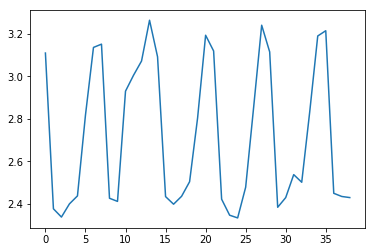

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.699833   
air_0164b9927d20bcc3_2017-04-23              1.386165   
air_0241aa3964b7f861_2017-04-23              2.323089   
air_0328696196e46f18_2017-04-23              2.056628   
air_034a3d5b40d5b1b1_2017-04-23              3.458820   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.473033  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.999482  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.207158  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.819555  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.779439

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l2_3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')